In [4]:
import os
import math
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import clima_anom as ca
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [5]:
def distancia(lat1,lon1,lat2,lon2):
    dist = np.sqrt((lon2 - lon1) ** 2 + (lat2 - lat1) ** 2)
    return dist*100

In [6]:
class TaylorDiagram(object):
    """
    Taylor diagram.

    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.

        Parameters:

        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = np.pi
            rlocs = np.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = np.pi/2
        tlocs = np.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
#         self.smax = srange[1] * self.refstd + 796 # MODIFICADO POR ARTURO
        self.smax = srange[1] * self.refstd  # MODIFICADO POR ARTURO

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure(figsize=(12,8))

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlação")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Desviação Estandar")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd,'ko',ls='',ms=4,label=label)
        t = np.linspace(0, self.tmax)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t, r,'k--',linewidth=1,label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """
        l, = self.ax.plot(np.arccos(corrcoef), stddev,*args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""
        self._ax.grid(*args, **kwargs,linestyle='--',color='gray',linewidth=0.4)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax),np.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = np.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*np.cos(ts))
        contours = self.ax.contour(ts,rs,rms,levels,**kwargs)
        return contours

In [7]:
filename = '../shape/SaoPaulo_Fixed.shp'
shape = list(shpreader.Reader(filename).geometries())

In [8]:
Brasildat_dir = '/media/arturo/Arturo/Datos/BrasilDat/SP/BrasilDat_2018_03_5min_8kmx8km.nc'
Brasildat = ca.read_netcdf(Brasildat_dir,2)
lat = Brasildat['lat']
lon = Brasildat['lon']
time_B = Brasildat['time']
flash_B = Brasildat['flash']

lon2d, lat2d = np.meshgrid(lon,lat)
nt, ny, nx = np.shape(flash_B)

lat : (45,)
lon : (45,)
time : (8928,)
flash : (8928, 45, 45)


In [9]:
GLM_dir = '/media/arturo/Arturo/Datos/GLM/SP/GLM_2018_03_5min_8kmx8km.nc'
GLM = ca.read_netcdf(GLM_dir,2)
flash_G = GLM['flash']

lat : (45,)
lon : (45,)
time : (8928,)
flash : (8928, 45, 45)


In [10]:
lat_c = -22.8611
lon_c = -47.0563
r = (180)/111

In [11]:
Area_R = np.zeros([ny,nx])
for i in range(ny):
    for j in range(nx):
        Dist = distancia(lat_c,lon_c,lat[i],lon[j])
        if Dist <= 162:
            Area_R[i,j] = 1

In [12]:
G_new = np.zeros([nt,ny,nx])
B_new = np.zeros([nt,ny,nx])
for t in range(nt):
    for i in range(ny):
        for j in range(nx):
            if Area_R[i,j] == 1:
                G_new[t,i,j] = flash_G[t,i,j]
                B_new[t,i,j] = flash_B[t,i,j]
            else:
                G_new[t,i,j] = np.nan
                B_new[t,i,j] = np.nan

## ACumulados cada 5min

In [13]:
B_acumm_5min = np.zeros(nt)
G_acumm_5min = np.zeros(nt)
for t in range(nt):
    B_acumm_5min[t] = np.nansum(np.nansum(B_new[t,:,:],axis=0))
    G_acumm_5min[t] = np.nansum(np.nansum(G_new[t,:,:],axis=0))

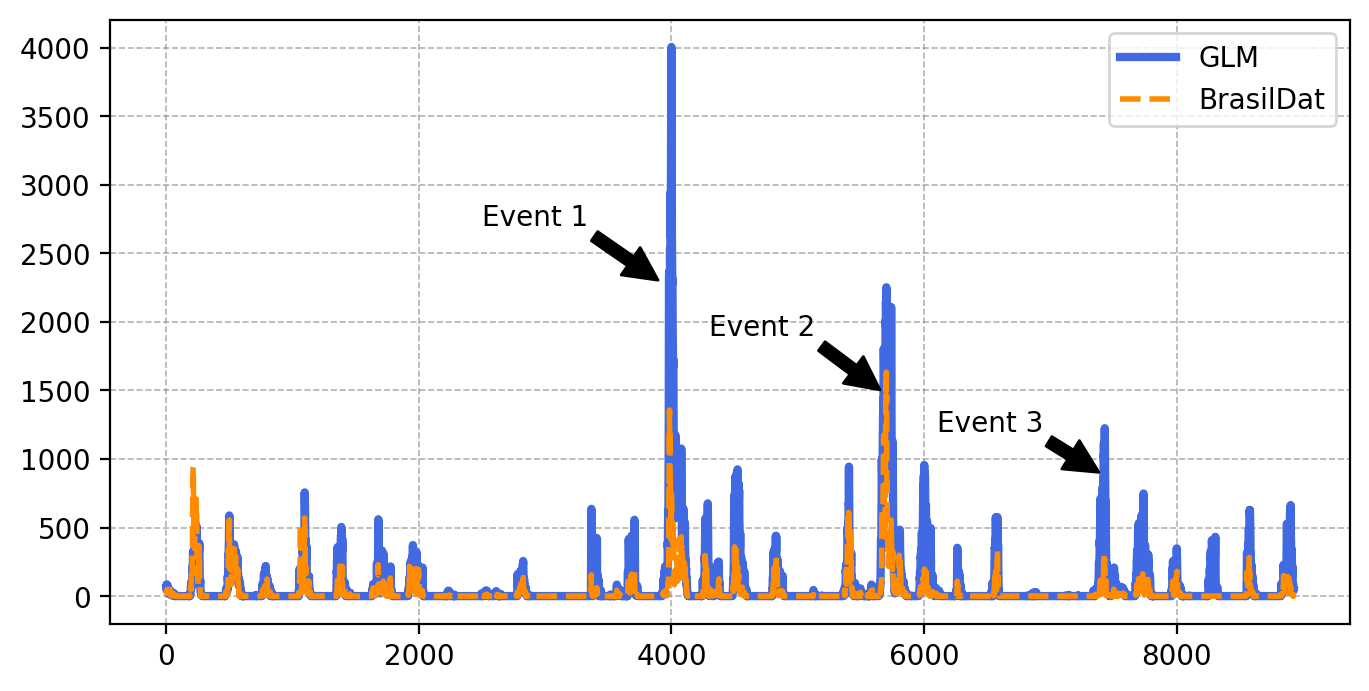

In [16]:
fig = plt.figure(figsize=(8,4),dpi=200)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(G_acumm_5min,linewidth=3,label='GLM',color='royalblue')
ax1.plot(B_acumm_5min,linewidth=2,linestyle='--',label='BrasilDat',color='darkorange')
ax1.legend()   
ax1.grid(True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
ax1.annotate('Event 1', xy=(3900,2300), xytext=(2500,2700),arrowprops=dict(facecolor='black', shrink=0.01))
ax1.annotate('Event 2', xy=(5657,1500), xytext=(4300,1900),arrowprops=dict(facecolor='black', shrink=0.01))
ax1.annotate('Event 3', xy=(7390,900), xytext=(6100,1200),arrowprops=dict(facecolor='black', shrink=0.01))

salida = '../fig/GLM_Brasildat_SerieT.jpeg'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

## Event 1

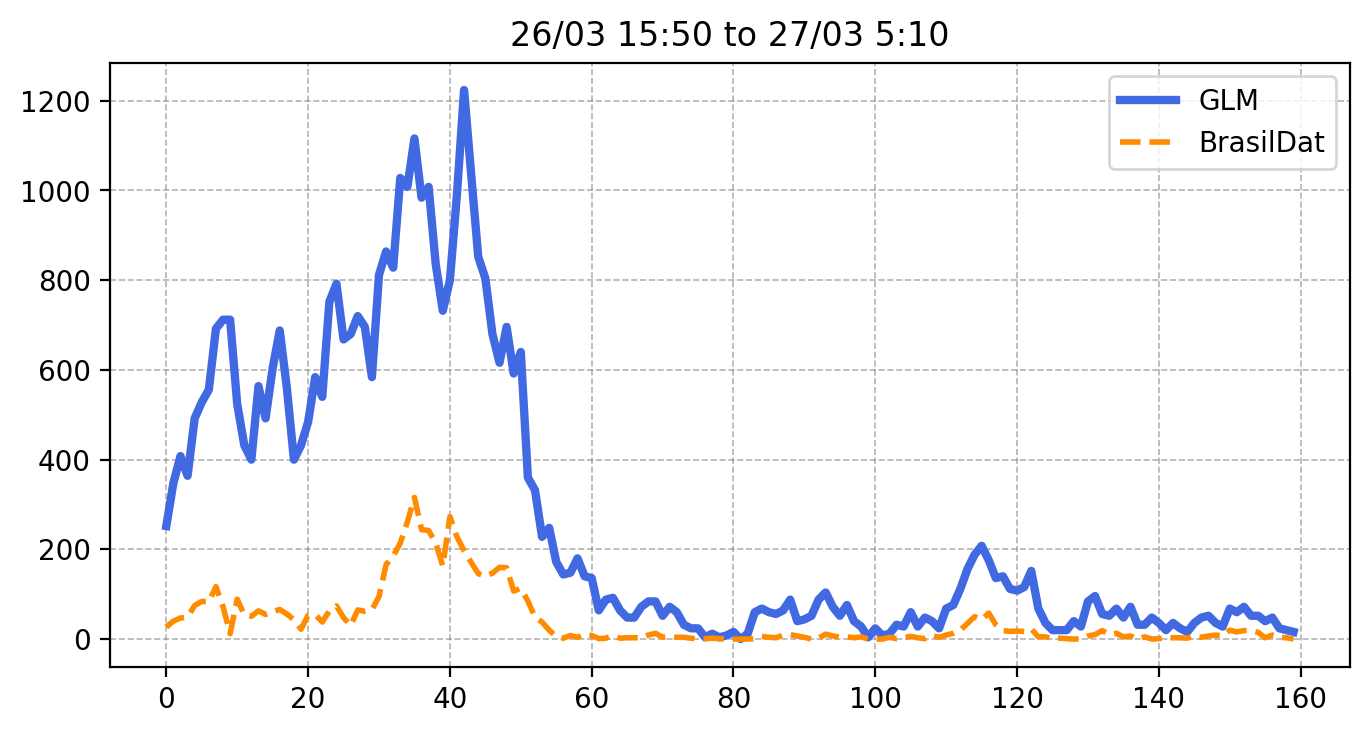

In [20]:
# Evento 1
# t_start = 3975
# t_end = 4125
# salida = '../fig/GLM_Brasildat_Evento1_serie_data.jpeg'

# Evento 2
# t_start = 5657
# t_end = 5850
# salida = '../fig/GLM_Brasildat_Evento2_serie_data.jpeg'

# Evento 3
t_start = 7390
t_end = 7550
salida = '../fig/GLM_Brasildat_Evento3_serie_data.jpeg'

fig = plt.figure(figsize=(8,4),dpi=200)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(G_acumm_5min[t_start:t_end],linewidth=3,label='GLM',color='royalblue')
ax1.plot(B_acumm_5min[t_start:t_end],linewidth=2,linestyle='--',label='BrasilDat',color='darkorange')
ax1.legend()   
ax1.grid(True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')

time_t1 = time_B[t_start]
time_t2 = time_B[t_end]
title_t1 = str(time_t1.day) + '/03 ' + str(time_t1.hour) + ':' + str(time_t1.minute)
title_t2 = str(time_t2.day) + '/03 ' + str(time_t2.hour) + ':' + str(time_t2.minute)

plt.title(title_t1 + ' to ' + title_t2)

plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

## Analisis y Plot cada 5 min

In [21]:
# Evento 1
# tt = 3975 #14 19:15
# tt = 3976
# tt = 3977
# tt = 3978
# tt = 3979
# tt = 3980
# tt = 3981
# tt = 3982 #14 19:50
# tt = 3983
# tt = 3984
# tt = 3985
# tt = 3996
# tt = 3997
# tt = 3998
# tt = 3999
# tt = 4000 #14 21:20
# tt = 4001
# tt = 4002
# tt = 4003
# tt = 4004
# tt = 4005
# tt = 4006
# tt = 4007
tt = 4008 #14 22:00
tt = 4009
tt = 4010
tt = 4011
tt = 4012
tt = 4013
tt = 4014
tt = 4015
tt = 4016
tt = 4017
tt = 4018
tt = 4019
tt = 4020
tt = 4021

# Evento 2
# tt = 5688 #20 18:00
# tt = 5689
# tt = 5690
# tt = 5691
# tt = 5692
# tt = 5693
# tt = 5694
# tt = 5695
# tt = 5696
# tt = 5697
# tt = 5698
# tt = 5699 #20 18:55

# Evento 3
# tt = 7425 #26 18:45
# tt = 7426
# tt = 7427
# tt = 7428
# tt = 7429
# tt = 7430
# tt = 7431
# tt = 7432
# tt = 7433
# tt = 7434
# tt = 7435
# tt = 7436
# tt = 7437
# tt = 7438
# tt = 7439 #26 19:55

date = time_B[tt]

di = ("{:02d}".format(date.day))
ho = ("{:02d}".format(date.hour))
mi = ("{:02d}".format(date.minute))

print(date)

2018-03-14 23:05:00


In [22]:
serieG = np.reshape(G_new[tt,:,:],ny*nx)
serieB = np.reshape(B_new[tt,:,:],ny*nx)

J = np.zeros([ny*nx,2])
J[:,0] = serieG
J[:,1] = serieB

G_clear = []
B_clear = []

for i in range(ny*nx):
    if math.isnan(J[i,0]) or math.isnan(J[i,1]):
        if i == ny:
            print(J[i,0],J[i,1])
    else:
        G_clear.append(J[i,0])
        B_clear.append(J[i,1])

nan nan


In [23]:
Regresion = np.zeros([3])
X_in = np.array(G_clear)
Y_in = np.array(B_clear)

X_train, X_test, y_train, y_test = train_test_split(X_in,Y_in, train_size = 0.8,random_state = 1234,shuffle = True)
corr_test = pearsonr(X_in,Y_in)

modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

Regresion[0] = corr_test[0]
Regresion[1] = modelo.coef_ #m
Regresion[2] = modelo.intercept_ #b

In [24]:
GLM_dir = '/media/arturo/Arturo/Datos/GLM/SP/5min/GLM_2018_03_'+di+'_'+ho+'_'+mi+'.csv'
Bra_dir = '/media/arturo/Arturo/Datos/BrasilDat/SP/5min/2018_03_'+di+'_'+ho+'_'+mi+'_new.csv'

print(GLM_dir)
print(Bra_dir)

if os.path.isfile(Bra_dir):
        GLM = pd.read_csv(GLM_dir)
        Bra = pd.read_csv(Bra_dir)
        
        lat_G = GLM['Lat']
        lon_G = GLM['Lon']

        lat_B = Bra['Lat']
        lon_B = Bra['Lon']
        
        lon_new = []
        lat_new = []
        for n in range(len(lat_G)):
            d = distancia(lat_c,lon_c,lat_G[n],lon_G[n])
            if d <= 162:
                lat_new.append(lat_G[n])
                lon_new.append(lon_G[n])
                
else:
    print('     No encontrado')

/media/arturo/Arturo/Datos/GLM/SP/5min/GLM_2018_03_14_23_05.csv
/media/arturo/Arturo/Datos/BrasilDat/SP/5min/2018_03_14_23_05_new.csv


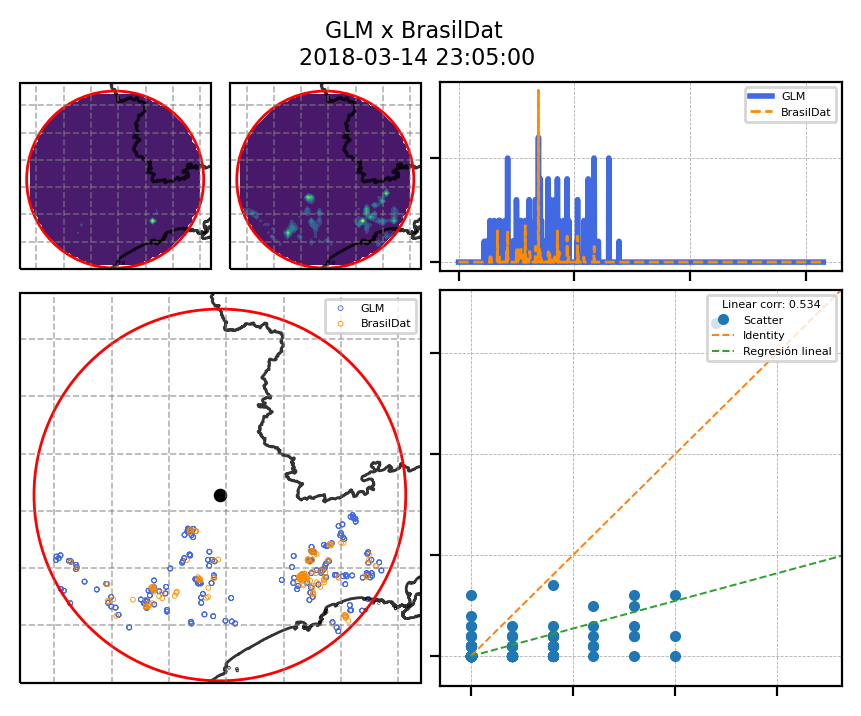

In [25]:
levels = None

fig = plt.figure(figsize=(5.3,3.9),dpi=200)

proj = ccrs.PlateCarree()

circle1 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle2 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle3 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)

gs = gridspec.GridSpec(3,4)

ax1 = plt.subplot(gs[0, 0], projection = proj) 
plt.contourf(lon2d,lat2d,B_new[tt,:,:],levels=levels)
ax1.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax1.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax1.add_artist(circle1)

ax2 = plt.subplot(gs[0, 1], projection = proj) 
plt.contourf(lon2d,lat2d,G_new[tt,:,:],levels=levels)
ax2.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax2.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax2.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax2.add_artist(circle2)

ax3 = plt.subplot(gs[1:3,0:2], projection = proj)
ax3.scatter(lon_c,lat_c,s=15,color='black')
ax3.scatter(lon_new,lat_new,s=3,color='royalblue',label='GLM',facecolor='None',linewidth=0.3)
ax3.scatter(lon_B,lat_B,s=3,color='darkorange',label='BrasilDat',facecolor='None',linewidth=0.3)
ax3.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax3.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax3.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax3.legend(fontsize=4,loc=1)
ax3.add_artist(circle3)

xx = np.arange(0,len(B_clear))
yy = xx
yy_regretion = Regresion[1] * xx + Regresion[2]

max_G = np.max(B_clear)
max_B = np.max(G_clear)

if max_G >= max_B:
    max_lim = max_G
else:
    max_lim = max_B

ax4 = plt.subplot(gs[0,2:4])
ax4.plot(G_clear,label='GLM',linewidth=2,color='royalblue')
ax4.plot(B_clear,label='BrasilDat',linewidth=1,linestyle='--',color='darkorange')
ax4.legend(fontsize=4,loc=1)
ax4.grid(linewidth=0.3,linestyle='--')
ax4.set_xticklabels([])
ax4.set_yticklabels([])

ax5 = plt.subplot(gs[1:3,2:4])
ax5.plot(G_clear,B_clear,'o',markersize=3,label='Scatter')
ax5.plot(xx,yy,'--',linewidth=0.7,label='Identity')
ax5.plot(xx,yy_regretion,'--',linewidth=0.7,label='Regresión lineal')
ax5.set_xlim(int(-1*max_lim/10),max_lim + (max_lim/10))
ax5.set_ylim(int(-1*max_lim/10),max_lim + (max_lim/10))
leg_title = 'Linear corr: '+ str(np.round(Regresion[0],3))
legend = ax5.legend(title=leg_title,loc=1, fontsize=4)
plt.setp(legend.get_title(),fontsize=4)
ax5.grid(linewidth=0.3,linestyle='--')
ax5.set_xticklabels([])
ax5.set_yticklabels([])

plt.suptitle('GLM x BrasilDat \n' + str(date),fontsize=8)
fig.subplots_adjust(top=0.9)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.1)

salida = '../fig/5min/GLM_Brasildat_2019_03_'+di+'_'+ho+'_'+mi+'.jpeg'
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

## Analisis y Plot Para cada evento

In [26]:
# Evento 1
#tt1 = 3975
#tt2 = 4126

# Evento 2
# tt1 = 5657
# tt2 = 5850

# # # Evento 3
# tt1 = 7390
# tt2 = 7550

# Total
tt1 = 0
tt2 = len(time_B)-1

date1 = time_B[tt1]
date2 = time_B[tt2]

di1 = ("{:02d}".format(date1.day))
ho1 = ("{:02d}".format(date1.hour))
mi1 = ("{:02d}".format(date1.minute))

di2 = ("{:02d}".format(date2.day))
ho2 = ("{:02d}".format(date2.hour))
mi2 = ("{:02d}".format(date2.minute))

print(date1)
print(date2)

2018-03-01 00:00:00
2018-03-31 23:55:00


In [27]:
len1 = len(time_B[tt1:tt2+1])
serieG = np.reshape(G_new[tt1:tt2+1,:,:],len1*ny*nx)
serieB = np.reshape(B_new[tt1:tt2+1,:,:],len1*ny*nx)

J = np.zeros([len1*ny*nx,2])
J[:,0] = serieG
J[:,1] = serieB

G_clear = []
B_clear = []

for i in range(len1*ny*nx):
    if math.isnan(J[i,0]) or math.isnan(J[i,1]):
        if i == len1*ny*nx:
            print(J[i,0],J[i,1])
    else:
        G_clear.append(J[i,0])
        B_clear.append(J[i,1])
        
print(len1)

8928


In [28]:
sumaG = np.nansum(G_new[tt1:tt2+1,:,:],axis=0)
sumaB = np.nansum(B_new[tt1:tt2+1,:,:],axis=0)

In [29]:
corr_1 = pearsonr(G_clear,B_clear)
print('Evento 1: ',corr_1[0])

event1_B = B_acumm_5min[tt1:tt2+1]
event1_G = G_acumm_5min[tt1:tt2+1]
corr_1 = pearsonr(event1_G,event1_B)
print('Evento 1: ',corr_1[0])

Evento 1:  0.4941890735456879
Evento 1:  0.8089594731539096


In [30]:
Regresion = np.zeros([3])
X_in = np.array(G_clear)
Y_in = np.array(B_clear)

X_train, X_test, y_train, y_test = train_test_split(X_in,Y_in, train_size = 0.8,random_state = 1234,shuffle = True)
corr_test = pearsonr(X_in,Y_in)

modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

Regresion[0] = corr_test[0]
Regresion[1] = modelo.coef_ #m
Regresion[2] = modelo.intercept_ #b

In [31]:
# Creando lista de horas por dia
horario = []
for d in range(int(di1),int(di2)+1):
    if d < int(di2): 
        horario.append(np.arange(int(ho1),25,1))
    else:
        horario.append(np.arange(0,int(ho2)+1,1))
        
# print(horario)

In [32]:
# Acumular puntos en eventos
count = 0

lon_newG = []
lat_newG = []

lon_newB = []
lat_newB = []

for d in range(int(di1),int(di2)+1):
    print('Dia: ',d)
    
    DiaN = ("{:02d}".format(d))
    
    if count == 0:
        for h in horario[0]:
            
            HoraN = ("{:02d}".format(h))
            
            for m in range(12):
                mm = 5*m
                MinN = ("{:02d}".format(mm))
                
                # print('   ',HoraN,MinN)
                
                GLM_dir = '/media/arturo/Arturo/Datos/GLM/SP/5min/GLM_2018_03_'+DiaN+'_'+HoraN+'_'+MinN+'.csv'
                Bra_dir = '/media/arturo/Arturo/Datos/BrasilDat/SP/5min/2018_03_'+DiaN+'_'+HoraN+'_'+MinN+'_new.csv'
                
                if os.path.isfile(Bra_dir):
                    GLM = pd.read_csv(GLM_dir)
                    Bra = pd.read_csv(Bra_dir)

                    lat_G = GLM['Lat']
                    lon_G = GLM['Lon']

                    lat_B = Bra['Lat']
                    lon_B = Bra['Lon']
                    
                    for n in range(len(lat_G)):
                        d = distancia(lat_c,lon_c,lat_G[n],lon_G[n])
                        if d <= 162:
                            lat_newG.append(lat_G[n])
                            lon_newG.append(lon_G[n])
                            
                    for n in range(len(lat_B)):
                        lat_newB.append(lat_B[n])
                        lon_newB.append(lon_B[n])
                            
                else:
                    print('     No encontrado',DiaN,HoraN,MinN)

    if count == 1:
        for h in horario[1]:
            
            HoraN = ("{:02d}".format(h))
            
            for m in range(12):
                mm = 5*m
                MinN = ("{:02d}".format(mm))
                
                # print('   ',HoraN,MinN)
                
                GLM_dir = '/media/arturo/Arturo/Datos/GLM/SP/5min/GLM_2018_03_'+DiaN+'_'+HoraN+'_'+MinN+'.csv'
                Bra_dir = '/media/arturo/Arturo/Datos/BrasilDat/SP/5min/2018_03_'+DiaN+'_'+HoraN+'_'+MinN+'_new.csv'
                
                if os.path.isfile(Bra_dir):
                    GLM = pd.read_csv(GLM_dir)
                    Bra = pd.read_csv(Bra_dir)

                    lat_G = GLM['Lat']
                    lon_G = GLM['Lon']

                    lat_B = Bra['Lat']
                    lon_B = Bra['Lon']

                    for n in range(len(lat_G)):
                        d = distancia(lat_c,lon_c,lat_G[n],lon_G[n])
                        if d <= 162:
                            lat_newG.append(lat_G[n])
                            lon_newG.append(lon_G[n])
                            
                    for n in range(len(lat_B)):
                        lat_newB.append(lat_B[n])
                        lon_newB.append(lon_B[n])   
                
                else:
                    print('     No encontrado',DiaN,HoraN,MinN)

    count = count + 1
    
print('Ok')

Dia:  1
    00 00
    00 05
    00 10
    00 15
    00 20
    00 25
    00 30
    00 35
    00 40
    00 45
    00 50
    00 55
    01 00
    01 05
    01 10
    01 15
    01 20
    01 25
    01 30
    01 35
    01 40
    01 45
    01 50
    01 55
    02 00
    02 05
    02 10
    02 15
    02 20
    02 25
    02 30
    02 35
    02 40
    02 45
    02 50
    02 55
    03 00
    03 05
    03 10
    03 15
    03 20
    03 25
    03 30
    03 35
    03 40
    03 45
    03 50
    03 55
    04 00
    04 05
    04 10
    04 15
    04 20
    04 25
    04 30
    04 35
    04 40
    04 45
    04 50
    04 55
    05 00
    05 05
    05 10
    05 15
    05 20
    05 25
    05 30
    05 35
    05 40
    05 45
    05 50
    05 55
    06 00
    06 05
    06 10
    06 15
    06 20
    06 25
    06 30
    06 35
    06 40
    06 45
    06 50
    06 55
    07 00
    07 05
    07 10
    07 15
    07 20
    07 25
    07 30
    07 35
    07 40
    07 45
    07 50
    07 55
    08 00
    08 05
    08 10
  

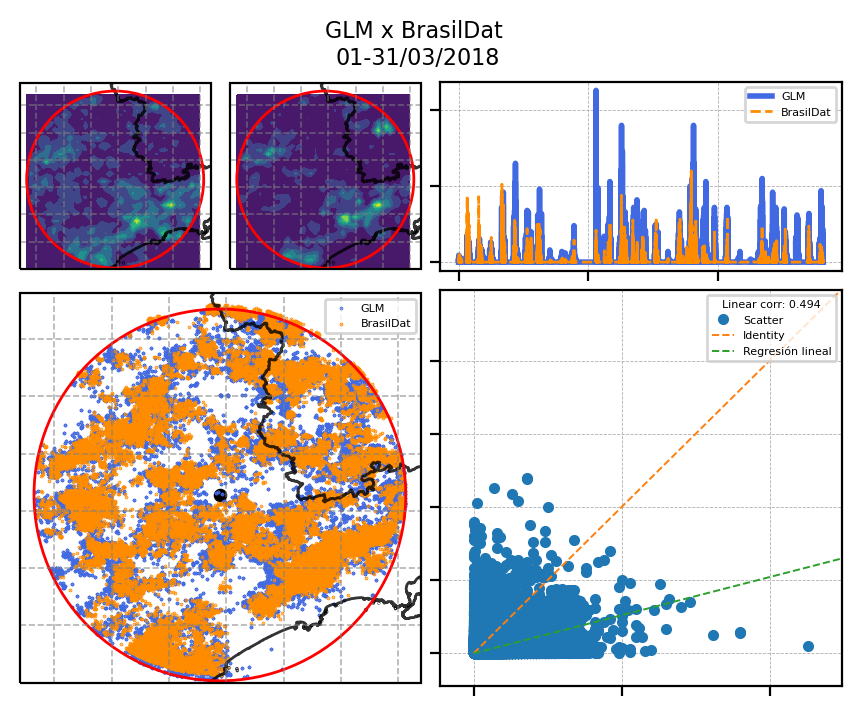

In [33]:
levels = None

fig = plt.figure(figsize=(5.3,3.9),dpi=200)

proj = ccrs.PlateCarree()

circle1 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle2 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle3 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)

gs = gridspec.GridSpec(3,4)

ax1 = plt.subplot(gs[0, 0], projection = proj) 
plt.contourf(lon2d,lat2d,sumaG,levels=levels)
ax1.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax1.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax1.add_artist(circle1)

ax2 = plt.subplot(gs[0, 1], projection = proj) 
plt.contourf(lon2d,lat2d,sumaB,levels=levels)
ax2.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax2.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax2.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax2.add_artist(circle2)

ax3 = plt.subplot(gs[1:3,0:2], projection = proj)
ax3.scatter(lon_c,lat_c,s=15,color='black')

ax3.scatter(lon_newG,lat_newG,s=0.1,color='royalblue',label='GLM')
ax3.scatter(lon_newB,lat_newB,s=0.1,color='darkorange',label='BrasilDat')

ax3.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax3.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax3.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax3.legend(fontsize=4,loc=1)
ax3.add_artist(circle3)

xx = np.arange(0,len(B_clear))
yy = xx
yy_regretion = Regresion[1] * xx + Regresion[2]

max_G = np.max(B_clear)
max_B = np.max(G_clear)

if max_G >= max_B:
    max_lim = max_G
else:
    max_lim = max_B

ax4 = plt.subplot(gs[0,2:4])
ax4.plot(G_clear,label='GLM',linewidth=2,color='royalblue')
ax4.plot(B_clear,label='BrasilDat',linewidth=1,linestyle='--',color='darkorange')
ax4.legend(fontsize=4,loc=1)
ax4.grid(linewidth=0.3,linestyle='--')
ax4.set_xticklabels([])
ax4.set_yticklabels([])

ax5 = plt.subplot(gs[1:3,2:4])

ax5.plot(G_clear,B_clear,'o',markersize=3,label='Scatter')
ax5.plot(xx,yy,'--',linewidth=0.7,label='Identity')
ax5.plot(xx,yy_regretion,'--',linewidth=0.7,label='Regresión lineal')
ax5.set_xlim(int(-1*max_lim/10),max_lim + (max_lim/10))
ax5.set_ylim(int(-1*max_lim/10),max_lim + (max_lim/10))
leg_title = 'Linear corr: '+ str(np.round(Regresion[0],3))
legend = ax5.legend(title=leg_title,loc=1, fontsize=4)
plt.setp(legend.get_title(),fontsize=4)
ax5.grid(linewidth=0.3,linestyle='--')
ax5.set_xticklabels([])
ax5.set_yticklabels([])

plt.suptitle('GLM x BrasilDat \n' + str(di1)+'-'+str(int(di2)) + '/03/2018',fontsize=8)
fig.subplots_adjust(top=0.9)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.1)

#salida = '../fig/GLM_Brasildat_Evento_'+di1+'_'+ho1+'_'+mi1+'.jpeg'
salida = '../fig/GLM_Brasildat_Total.jpeg'
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

## Acumulado Mensual

In [34]:
G_acumm_Mes = np.nansum(G_new,axis=0)
B_acumm_Mes = np.nansum(B_new,axis=0)
print(np.max(G_acumm_Mes),np.max(B_acumm_Mes))

2704.0 1562.0


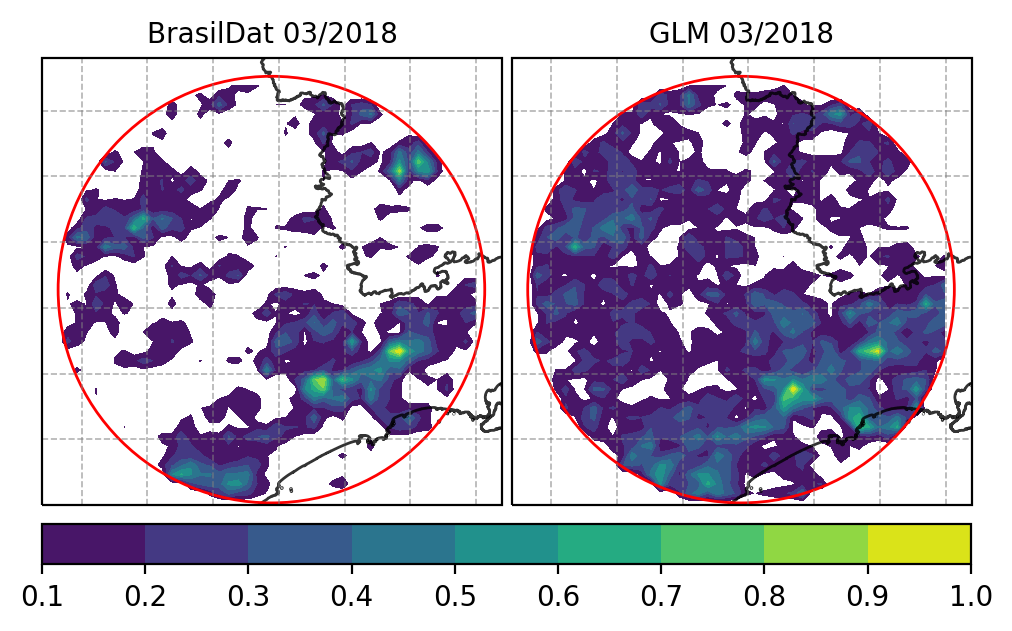

In [35]:
# levels = np.arange(200,6200,200)
levels = np.arange(0.1,1.1,0.1)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,4),dpi=200)
ax1 = plt.subplot(1,2,1, projection = proj)
ax2 = plt.subplot(1,2,2, projection = proj, sharex=ax1, sharey=ax1)

circle1 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle2 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)

a1 = ax1.contourf(lon2d,lat2d,B_acumm_Mes/np.nanmax(B_acumm_Mes),levels=levels)
ax1.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax1.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax1.add_artist(circle1)
ax1.set_title('BrasilDat 03/2018',fontsize=10)

a2 = ax2.contourf(lon2d,lat2d,G_acumm_Mes/np.nanmax(G_acumm_Mes),levels=levels)
ax2.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax2.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax2.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax2.add_artist(circle2)
ax2.set_title('GLM 03/2018',fontsize=10)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.02, wspace=0.02)

cbaxes = fig.add_axes([0.125, 0.15, 0.774, 0.05]) 
fig.colorbar(a2, cax = cbaxes,orientation="horizontal")

salida = '../fig/GLM_Brasildat_Total_mes_estandarizado.jpeg'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

In [98]:
G_acumm_Mes_serie = np.reshape(G_acumm_Mes,nx*ny)
B_acumm_Mes_serie = np.reshape(B_acumm_Mes,nx*ny)

In [99]:
Regresion = np.zeros([3])

X_train, X_test, y_train, y_test = train_test_split(G_acumm_Mes_serie,B_acumm_Mes_serie, train_size = 0.9,random_state = 1234,shuffle = True)
corr_test = pearsonr(G_acumm_Mes_serie,B_acumm_Mes_serie)

modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

Regresion[0] = corr_test[0]
Regresion[1] = modelo.coef_ #m
Regresion[2] = modelo.intercept_ #b

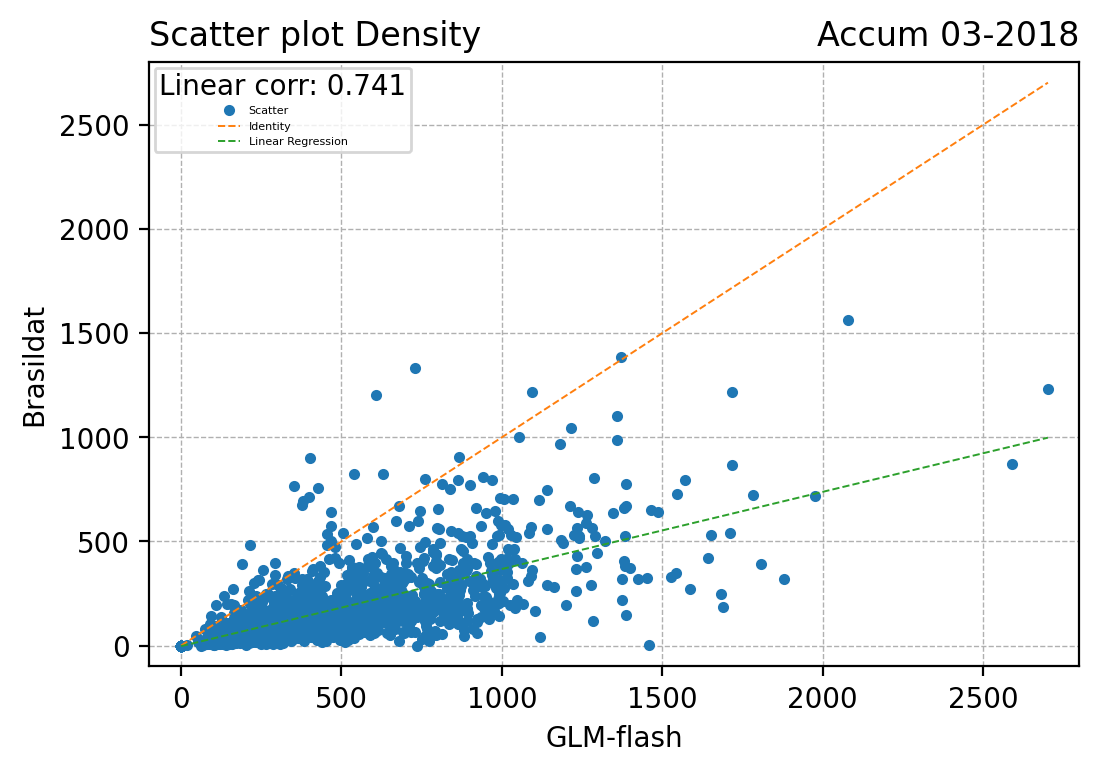

In [100]:
xx = np.arange(0,np.max(G_acumm_Mes_serie))
yy = xx
yy_regretion = Regresion[1] * xx + Regresion[2]

fig = plt.figure(figsize=(6,4),dpi=200)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(G_acumm_Mes_serie,B_acumm_Mes_serie,'.',label='Scatter')
ax1.plot(xx,yy,'--',linewidth=0.7,label='Identity')
ax1.plot(xx,yy_regretion,'--',linewidth=0.7,label='Linear Regression')

ax1.set_ylim(-100,2800)
ax1.set_xlim(-100,2800)

ax1.set_ylabel('Brasildat')
ax1.set_xlabel('GLM-flash')
ax1.set_title('Scatter plot Density',loc='left')
ax1.set_title('Accum 03-2018',loc='right')

leg_title = 'Linear corr: '+ str(np.round(Regresion[0],3))
legend = ax1.legend(title=leg_title,loc=2, fontsize=4)
plt.grid(linewidth=0.5,linestyle='--')

salida = '../fig/Scatter_GLM_BrasilDat_month_accum.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

In [93]:
G_acumm_Mes_serie = np.reshape(G_new,(nt*ny*nx))
B_acumm_Mes_serie = np.reshape(B_new,(nt*ny*nx))

x = np.where(~np.isnan(G_acumm_Mes_serie))[0]

G_acumm_Mes_serie = G_acumm_Mes_serie[x]
B_acumm_Mes_serie = B_acumm_Mes_serie[x]

In [94]:
Regresion = np.zeros([3])

X_train, X_test, y_train, y_test = train_test_split(G_acumm_Mes_serie,B_acumm_Mes_serie, train_size = 0.9,random_state = 1234,shuffle = True)
corr_test = pearsonr(G_acumm_Mes_serie,B_acumm_Mes_serie)

modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

Regresion[0] = corr_test[0]
Regresion[1] = modelo.coef_ #m
Regresion[2] = modelo.intercept_ #b

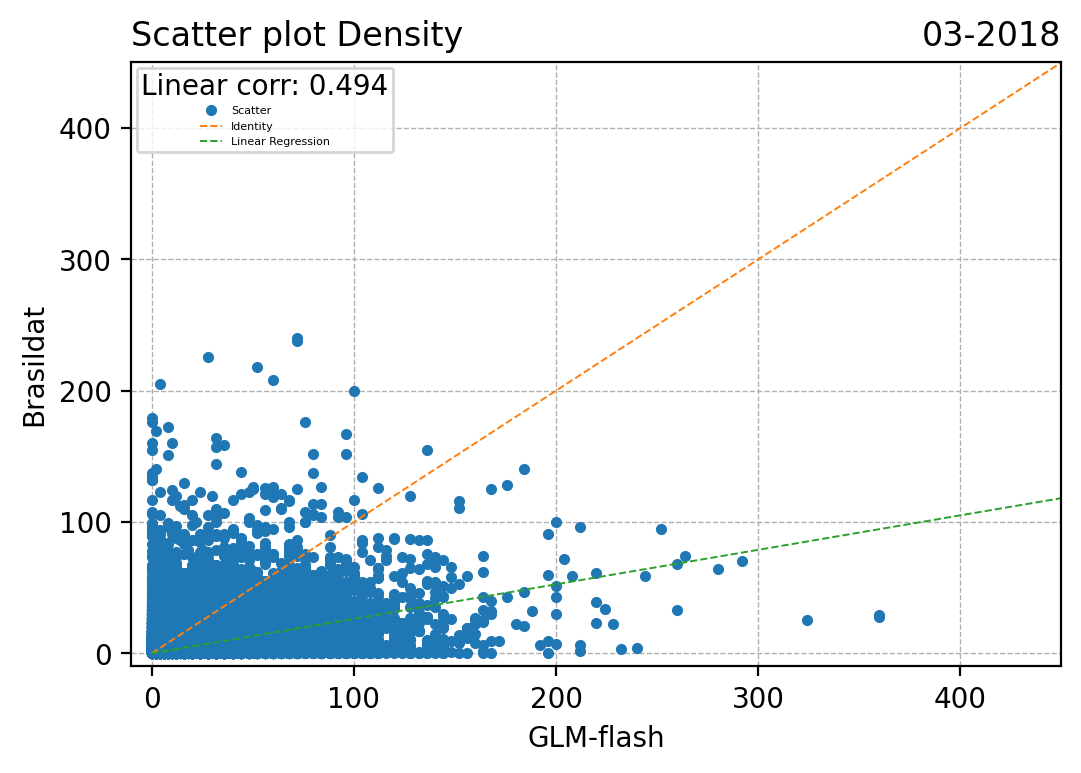

In [97]:
xx = np.arange(0,np.max(G_acumm_Mes_serie))
yy = xx
yy_regretion = Regresion[1] * xx + Regresion[2]

fig = plt.figure(figsize=(6,4),dpi=200)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(G_acumm_Mes_serie,B_acumm_Mes_serie,'.',label='Scatter')
ax1.plot(xx,yy,'--',linewidth=0.7,label='Identity')
ax1.plot(xx,yy_regretion,'--',linewidth=0.7,label='Linear Regression')

ax1.set_ylim(-10,450)
ax1.set_xlim(-10,450)

ax1.set_ylabel('Brasildat')
ax1.set_xlabel('GLM-flash')
ax1.set_title('Scatter plot Density',loc='left')
ax1.set_title('03-2018',loc='right')

leg_title = 'Linear corr: '+ str(np.round(Regresion[0],3))
legend = ax1.legend(title=leg_title,loc=2, fontsize=4)
plt.grid(linewidth=0.5,linestyle='--')

salida = '../fig/Scatter_GLM_BrasilDat_month.png'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor='white')

## Correlacion para cada evento

In [47]:
# event1_B = B_acumm_5min[3975:4126]
# event1_G = G_acumm_5min[3975:4126]
# corr_1 = pearsonr(event1_G,event1_B)
# print('Evento 1: ',corr_1[0])

# event2_B = B_acumm_5min[5657:5851]
# event2_G = G_acumm_5min[5657:5851]
# corr_2 = pearsonr(event2_G,event2_B)
# print('Evento 2: ',corr_2[0])

# event3_B = B_acumm_5min[7390:7550]
# event3_G = G_acumm_5min[7390:7550]
# corr_3 = pearsonr(event3_G,event3_B)
# print('Evento 3: ',corr_3[0])

In [102]:
len1 = len(time_B[3975:4126])
serieG = np.reshape(G_new[3975:4126,:,:],len1*ny*nx)
serieB = np.reshape(B_new[3975:4126,:,:],len1*ny*nx)
J = np.zeros([len1*ny*nx,2])
J[:,0] = serieG
J[:,1] = serieB

G1_clear = []
B1_clear = []

for i in range(len1*ny*nx):
    if math.isnan(J[i,0]) or math.isnan(J[i,1]):
        if i == len1*ny*nx:
            print(J[i,0],J[i,1])
    else:
        G1_clear.append(J[i,0])
        B1_clear.append(J[i,1])
corr_1 = pearsonr(G1_clear,B1_clear)

#=========================================================================
len1 = len(time_B[5657:5851])
serieG = np.reshape(G_new[5657:5851,:,:],len1*ny*nx)
serieB = np.reshape(B_new[5657:5851,:,:],len1*ny*nx)
J = np.zeros([len1*ny*nx,2])
J[:,0] = serieG
J[:,1] = serieB

G2_clear = []
B2_clear = []

for i in range(len1*ny*nx):
    if math.isnan(J[i,0]) or math.isnan(J[i,1]):
        if i == len1*ny*nx:
            print(J[i,0],J[i,1])
    else:
        G2_clear.append(J[i,0])
        B2_clear.append(J[i,1])
corr_2 = pearsonr(G2_clear,B2_clear)

#=========================================================================
len1 = len(time_B[7390:7550])
serieG = np.reshape(G_new[7390:7550,:,:],len1*ny*nx)
serieB = np.reshape(B_new[7390:7550,:,:],len1*ny*nx)
J = np.zeros([len1*ny*nx,2])
J[:,0] = serieG
J[:,1] = serieB

G3_clear = []
B3_clear = []

for i in range(len1*ny*nx):
    if math.isnan(J[i,0]) or math.isnan(J[i,1]):
        if i == len1*ny*nx:
            print(J[i,0],J[i,1])
    else:
        G3_clear.append(J[i,0])
        B3_clear.append(J[i,1])
corr_3 = pearsonr(G3_clear,B3_clear)

In [103]:
event1_G = np.array(G1_clear)
event1_B = np.array(B1_clear)

event2_G = np.array(G2_clear)
event2_B = np.array(B2_clear)

event3_G = np.array(G3_clear)
event3_B = np.array(B3_clear)

In [104]:
X_train,X_test,y_train,y_test=train_test_split(event1_G,event1_B,train_size=0.9,random_state=1234,shuffle=True)
modelo1 = LinearRegression()
modelo1.fit(X = X_train.reshape(-1, 1), y = y_train)

X_train,X_test,y_train,y_test=train_test_split(event2_G,event2_B,train_size=0.9,random_state=1234,shuffle=True)
modelo2 = LinearRegression()
modelo2.fit(X = X_train.reshape(-1, 1), y = y_train)

X_train,X_test,y_train,y_test=train_test_split(event3_G,event3_B,train_size=0.9,random_state=1234,shuffle=True)
modelo3 = LinearRegression()
modelo3.fit(X = X_train.reshape(-1, 1), y = y_train)

LinearRegression()

In [105]:
Regresion = np.zeros([3,3])

Regresion[0,0] = corr_1[0]
Regresion[1,0] = modelo1.coef_ #m
Regresion[2,0] = modelo1.intercept_ #b

Regresion[0,1] = corr_2[0]
Regresion[1,1] = modelo2.coef_ #m
Regresion[2,1] = modelo2.intercept_ #b

Regresion[0,2] = corr_3[0]
Regresion[1,2] = modelo2.coef_ #m
Regresion[2,2] = modelo2.intercept_ #b

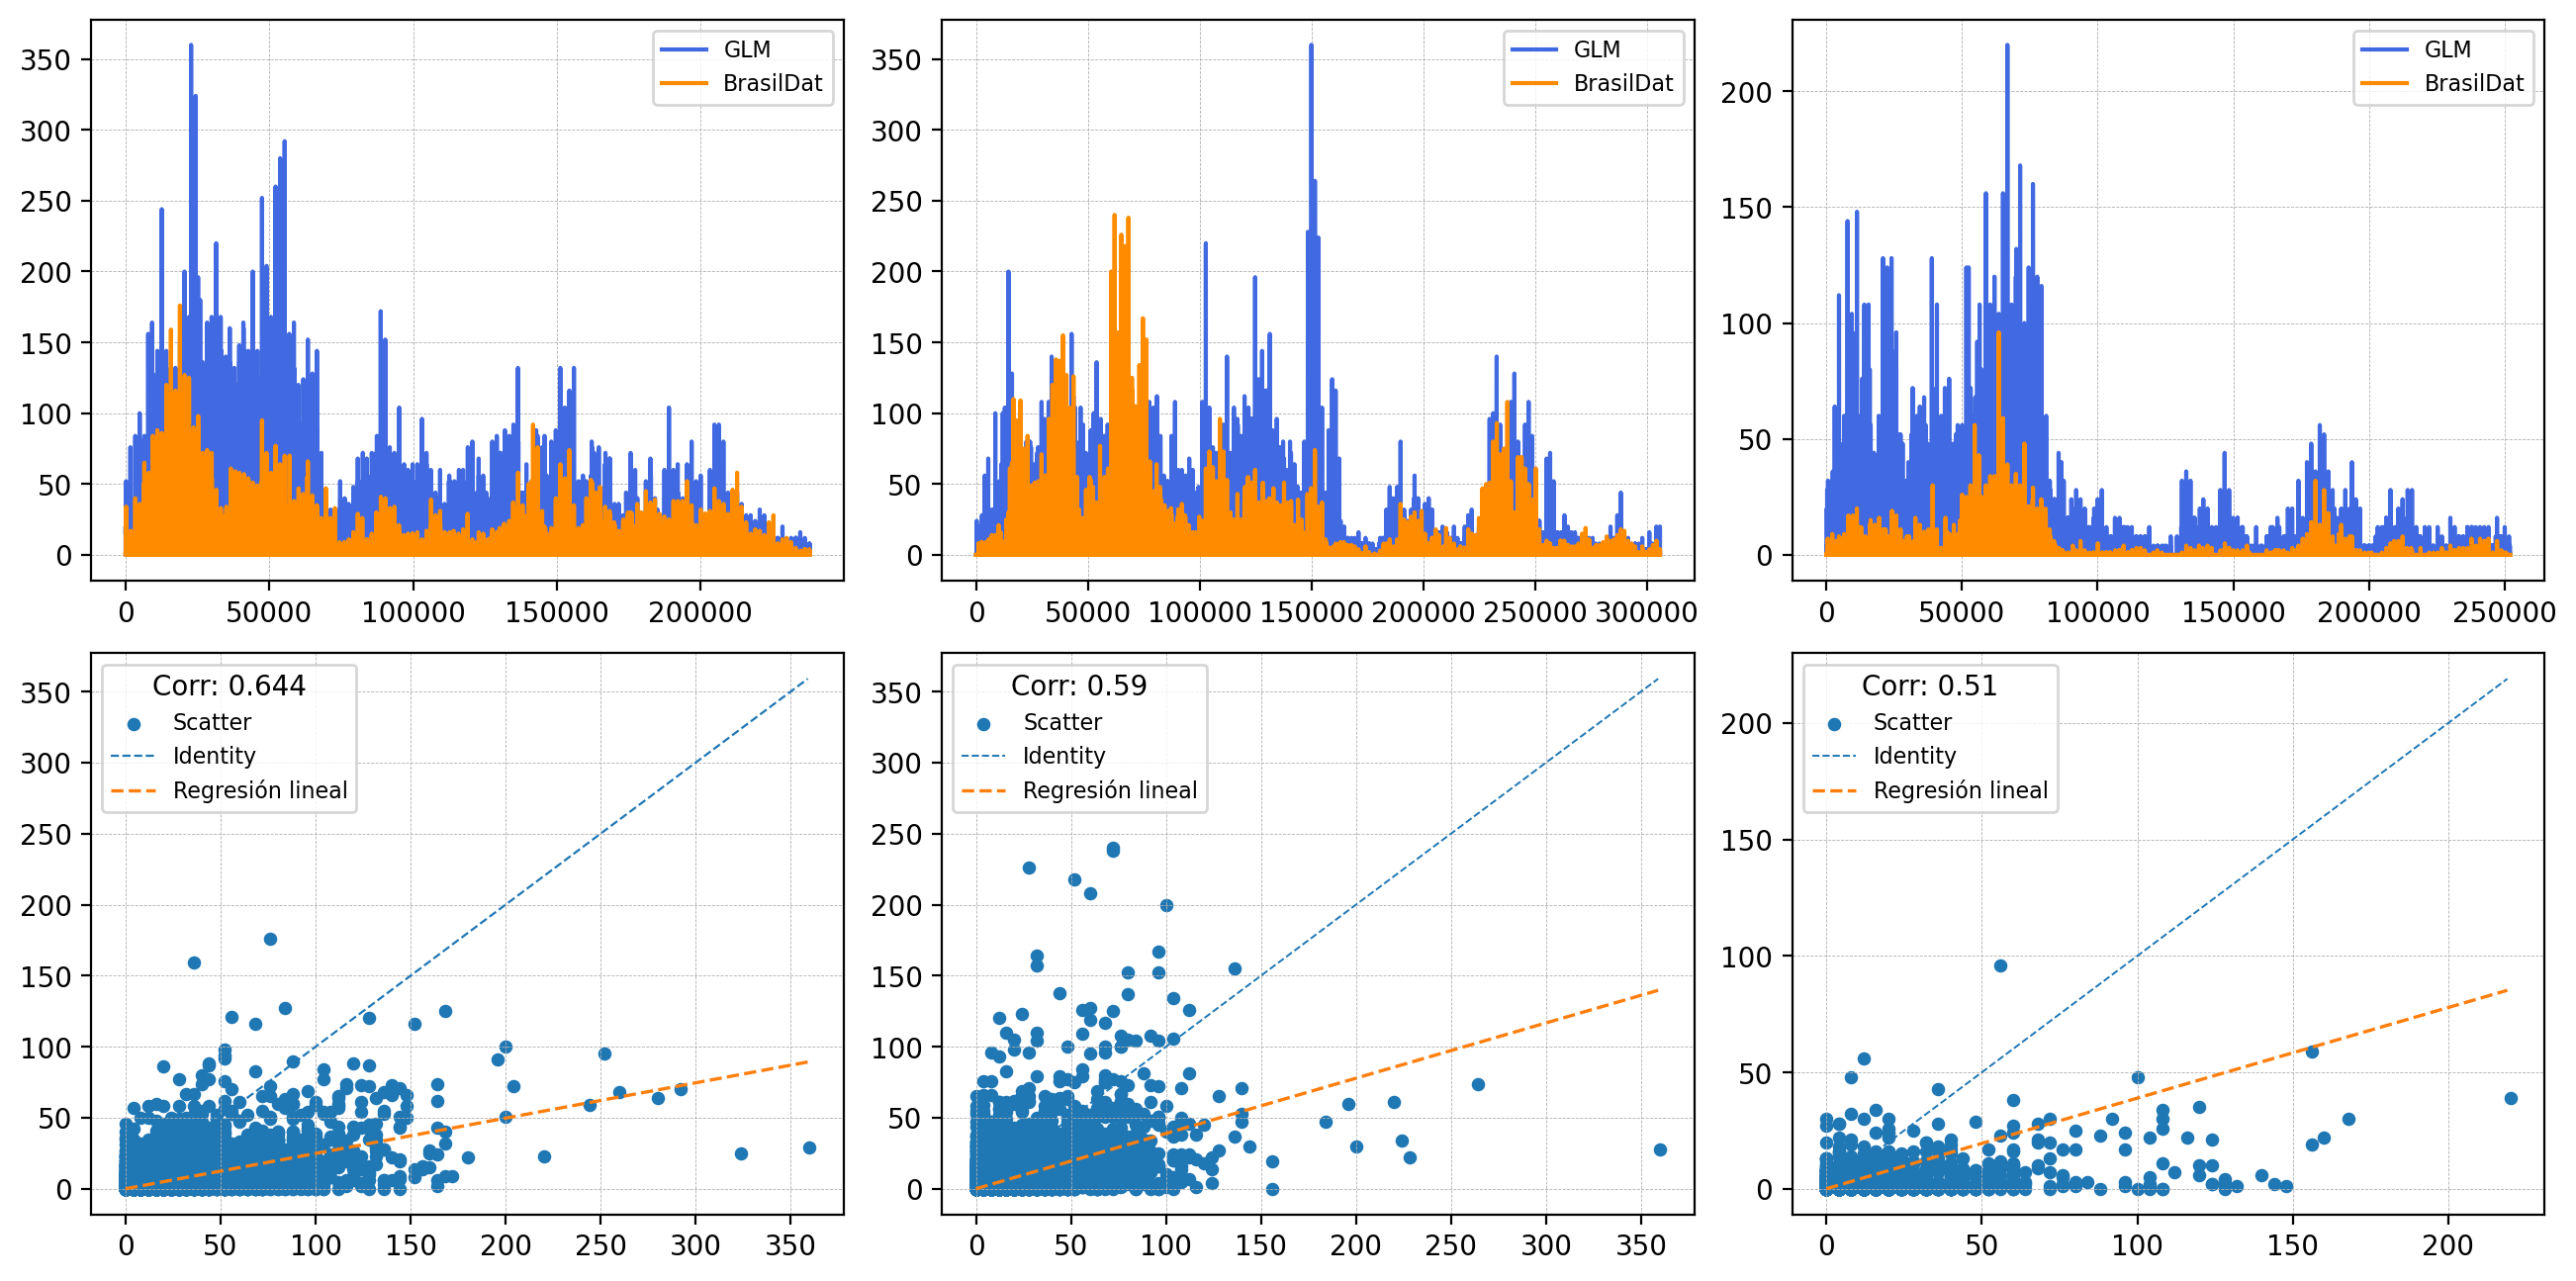

In [107]:
fig = plt.figure(figsize=(16,8),dpi=200)

circle1 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle2 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle3 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)

x1 = np.arange(np.max(event1_G))
x2 = np.arange(np.max(event2_G))
x3 = np.arange(np.max(event3_G))

y_r1 = Regresion[1,0] * x1 + Regresion[2,0]
y_r2 = Regresion[1,1] * x2 + Regresion[2,1]
y_r3 = Regresion[1,2] * x3 + Regresion[2,2]

gs = gridspec.GridSpec(2,3)

ax1 = plt.subplot(gs[0, 0]) 
ax1.plot(event1_G,label='GLM',color='royalblue')
ax1.plot(event1_B,label='BrasilDat',color='darkorange')
ax1.grid(True,linewidth=0.3,linestyle='--')
ax1.legend(loc=1, fontsize=8, fancybox=True)

ax2 = plt.subplot(gs[1::, 0]) 
ax2.scatter(event1_G,event1_B,s=15,label='Scatter')
ax2.plot(x1,x1,'--',linewidth=0.8,label='Identity')
ax2.plot(x1,y_r1,'--',linewidth=1.2,label='Regresión lineal')
ax2.grid(True,linewidth=0.3,linestyle='--')
leg_title = 'Corr: '+ str(np.round(Regresion[0,0],3))
ax2.legend(title=leg_title,loc=2, fontsize=8, fancybox=True)

ax3 = plt.subplot(gs[0, 1]) 
ax3.plot(event2_G,label='GLM',color='royalblue')
ax3.plot(event2_B,label='BrasilDat',color='darkorange')
ax3.grid(True,linewidth=0.3,linestyle='--')
ax3.legend(loc=1, fontsize=8, fancybox=True)

ax4 = plt.subplot(gs[1::, 1]) 
ax4.scatter(event2_G,event2_B,s=15,label='Scatter')
ax4.plot(x2,x2,'--',linewidth=0.7,label='Identity')
ax4.plot(x2,y_r2,'--',linewidth=1.2,label='Regresión lineal')
ax4.grid(True,linewidth=0.3,linestyle='--')
leg_title = 'Corr: '+ str(np.round(Regresion[0,1],3))
ax4.legend(title=leg_title,loc=2, fontsize=8, fancybox=True)

ax5 = plt.subplot(gs[0, 2]) 
ax5.plot(event3_G,label='GLM',color='royalblue')
ax5.plot(event3_B,label='BrasilDat',color='darkorange')
ax5.grid(True,linewidth=0.3,linestyle='--')
ax5.legend(loc=1, fontsize=8, fancybox=True)

ax6 = plt.subplot(gs[1::, 2]) 
ax6.scatter(event3_G,event3_B,s=15,label='Scatter')
ax6.plot(x3,x3,'--',linewidth=0.7,label='Identity')
ax6.plot(x3,y_r3,'--',linewidth=1.2,label='Regresión lineal')
ax6.grid(True,linewidth=0.3,linestyle='--')
leg_title = 'Corr: '+ str(np.round(Regresion[0,2],3))
ax6.legend(title=leg_title,loc=2, fontsize=8, fancybox=True)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.13, wspace=0.13)

salida = '../fig/GLM_Brasildat_eventos.jpeg'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

In [108]:
serie_corr_T = np.zeros([25,6])
for tt in range(6):
    
    serie_corr = np.zeros([25])
    
    if tt == 0:
        time_st = 3900 #3975
        time_en = 4130
    elif tt ==1:
        time_st = 5657
        time_en = 5851
    elif tt ==2:
        time_st = 7390
        time_en = 7550
    elif tt ==3:
        time_st = 0 +12
        time_en = len(B_acumm_5min) -12
    elif tt ==4:
        time_st = 0 +12
        time_en = int(len(B_acumm_5min)/2) -12
    elif tt ==5:
        time_st = int(len(B_acumm_5min)/2) +12
        time_en = len(B_acumm_5min) -12

    serie_corr[0] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st-12:time_en-12])[0] # -60min
    serie_corr[1] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st-11:time_en-11])[0] # -55min
    serie_corr[2] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st-10:time_en-10])[0] # -50min
    serie_corr[3] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st-9:time_en-9])[0] # -45min
    serie_corr[4] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st-8:time_en-8])[0] # -40min
    serie_corr[5] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st-7:time_en-7])[0] # -35min
    serie_corr[6] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st-6:time_en-6])[0] # -30min
    serie_corr[7] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st-5:time_en-5])[0] # -25min
    serie_corr[8] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st-4:time_en-4])[0] # -20min
    serie_corr[9] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st-3:time_en-3])[0] # -15min
    serie_corr[10] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st-2:time_en-2])[0] # -10min
    serie_corr[11] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st-1:time_en-1])[0] # -5min

    serie_corr[12] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st:time_en])[0] # 0min

    serie_corr[13] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st+1:time_en+1])[0] # +5min
    serie_corr[14] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st+2:time_en+2])[0] # +10min
    serie_corr[15] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st+3:time_en+3])[0] # +15min
    serie_corr[16] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st+4:time_en+4])[0] # +20min
    serie_corr[17] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st+5:time_en+5])[0] # +25min
    serie_corr[18] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st+6:time_en+6])[0] # +30min
    serie_corr[19] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st+7:time_en+7])[0] # +35min
    serie_corr[20] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st+8:time_en+8])[0] # +40min
    serie_corr[21] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st+9:time_en+9])[0] # +45min
    serie_corr[22] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st+10:time_en+10])[0] # +50min
    serie_corr[23] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st+11:time_en+11])[0] # +55min
    serie_corr[24] = pearsonr(B_acumm_5min[time_st:time_en],G_acumm_5min[time_st+12:time_en+12])[0] # +60min
    
    serie_corr_T[:,tt] = serie_corr

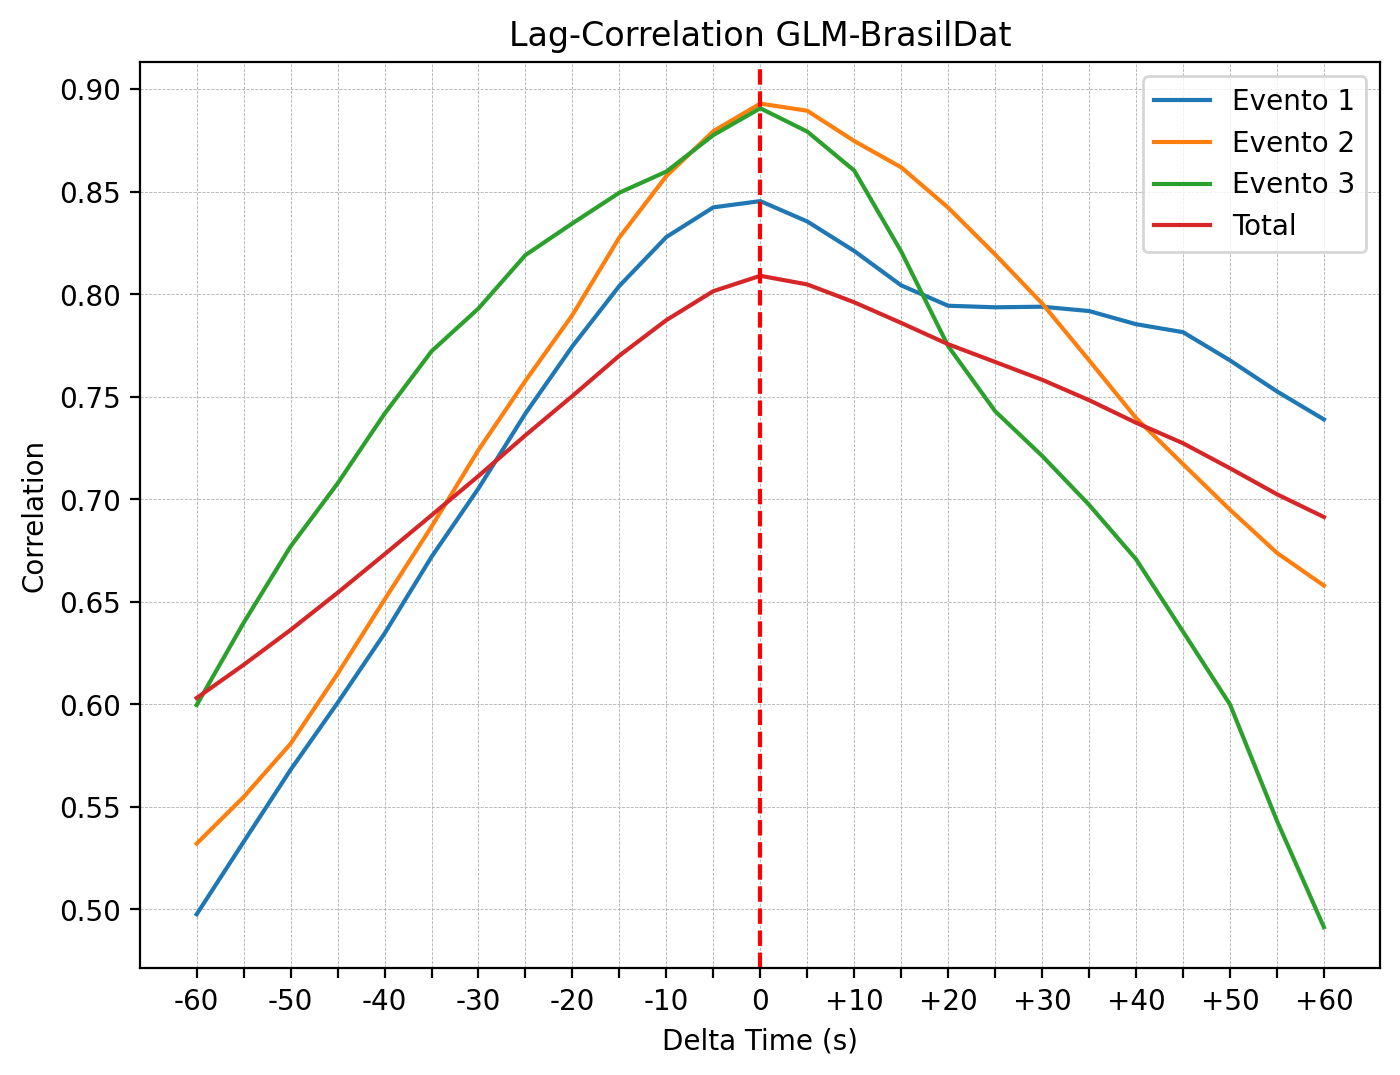

In [111]:
fig = plt.figure(figsize=(8,6),dpi=200)
xtick = np.arange(len(serie_corr))
plt.plot(serie_corr_T[:,0],label='Evento 1')
plt.plot(serie_corr_T[:,1],label='Evento 2')
plt.plot(serie_corr_T[:,2],label='Evento 3')
plt.plot(serie_corr_T[:,3],label='Total')
plt.axvline(x=12, color='r', linestyle='--')

plt.legend()
plt.xticks(xtick, ('-60','','-50','','-40','','-30','','-20','','-10','',
               '0',
               '','+10','','+20','','+30','','+40','','+50','','+60'))
plt.grid(True,linewidth=0.3,linestyle='--')
plt.xlabel('Delta Time (s)')
plt.ylabel('Correlation')

plt.title('Lag-Correlation GLM-BrasilDat')

salida = '../fig/GLM_Brasildat_eventos_cor.jpeg'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

In [114]:
accum_G_1h = np.reshape(np.nansum(G_new[192:204,:,:],axis = 0),ny*nx)
accum_G_12h = np.reshape(np.nansum(G_new[192:336,:,:],axis = 0),ny*nx)
accum_G_1d = np.reshape(np.nansum(G_new[192:480,:,:],axis = 0),ny*nx)
accum_G_4d = np.reshape(np.nansum(G_new[192:1344,:,:],axis = 0),ny*nx)
accum_G_10d = np.reshape(np.nansum(G_new[192:3072,:,:],axis = 0),ny*nx)
accum_G_15d = np.reshape(np.nansum(G_new[192:4512,:,:],axis = 0),ny*nx)

In [115]:
accum_B_1h = np.reshape(np.nansum(B_new[192:204,:,:],axis = 0),ny*nx)
accum_B_12h = np.reshape(np.nansum(B_new[192:336,:,:],axis = 0),ny*nx)
accum_B_1d = np.reshape(np.nansum(B_new[192:480,:,:],axis = 0),ny*nx)
accum_B_4d = np.reshape(np.nansum(B_new[192:1344,:,:],axis = 0),ny*nx)
accum_B_10d = np.reshape(np.nansum(B_new[192:3072,:,:],axis = 0),ny*nx)
accum_B_15d = np.reshape(np.nansum(B_new[192:4512,:,:],axis = 0),ny*nx)

In [116]:
# Modelo de regresion lineal
Regresion = np.zeros([6,3])
for i in range(6):
    
    if i == 0:
        X = accum_G_1h
        y = accum_B_1h
    elif i == 1:
        X = accum_G_12h
        y = accum_B_12h
    elif i == 2:
        X = accum_G_1d
        y = accum_B_1d
    elif i == 3:
        X = accum_G_4d
        y = accum_B_4d
    elif i == 4:
        X = accum_G_10d
        y = accum_B_10d
    elif i == 5:
        X = accum_G_15d
        y = accum_B_15d
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8,random_state = 1234,shuffle = True)
    corr_test = pearsonr(X,y)

    modelo = LinearRegression()
    modelo.fit(X = X_train.reshape(-1, 1), y = y_train)
    
    Regresion[i,0] = corr_test[0]
    Regresion[i,1] = modelo.coef_ #m
    Regresion[i,2] = modelo.intercept_ #b

In [117]:
#1h
xlim0 = np.max(accum_G_1h)
xx0 = np.arange(xlim0)
yy0 = xx0
Reg0 = Regresion[0,1]*xx0 + Regresion[0,2]

#12h
xlim1 = np.max(accum_G_12h)
xx1 = np.arange(xlim1)
yy1 = xx1
Reg1 = Regresion[1,1]*xx1 + Regresion[1,2]

#1d
xlim2 = np.max(accum_G_1d)
xx2 = np.arange(xlim2)
yy2 = xx2
Reg2 = Regresion[2,1]*xx2 + Regresion[2,2]

#4d
xlim3 = np.max(accum_G_4d)
xx3 = np.arange(xlim3)
yy3 = xx3
Reg3 = Regresion[3,1]*xx3 + Regresion[3,2]

#4d
xlim4 = np.max(accum_G_10d)
xx4 = np.arange(xlim4)
yy4 = xx4
Reg4 = Regresion[4,1]*xx4 + Regresion[4,2]

#10d
xlim5 = np.max(accum_G_15d)
xx5 = np.arange(xlim5)
yy5 = xx5
Reg5 = Regresion[5,1]*xx5 + Regresion[5,2]

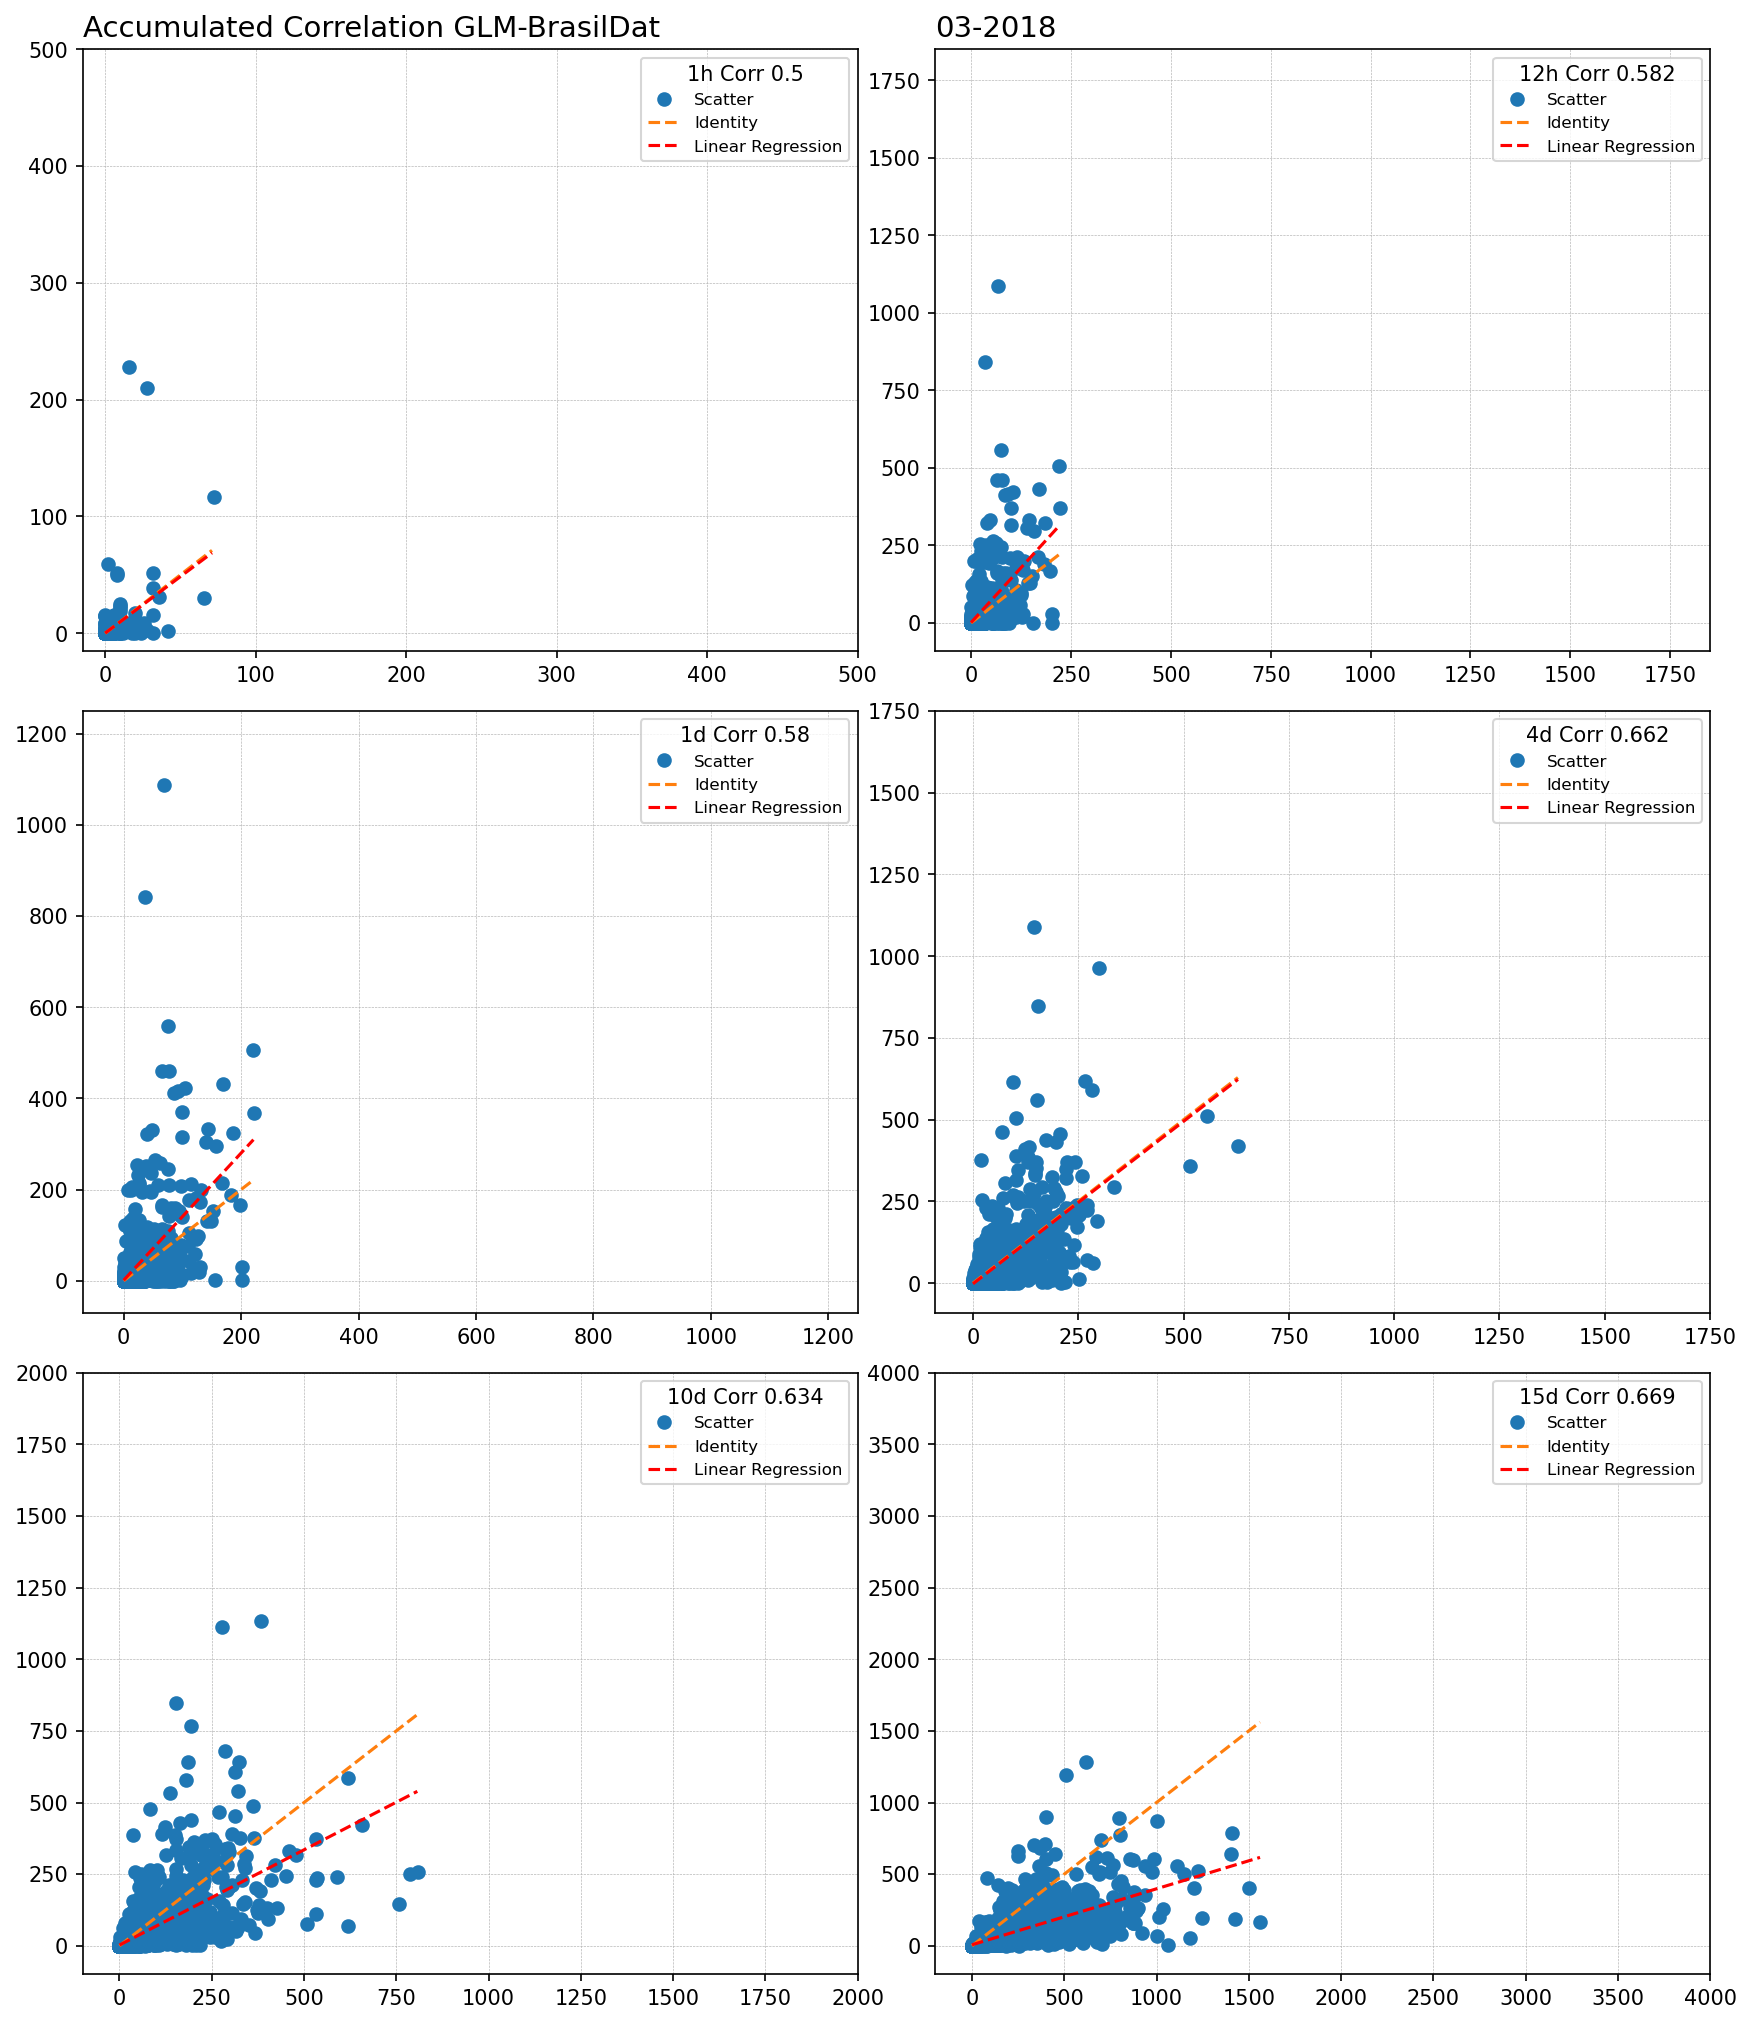

In [129]:
fig = plt.figure(figsize=(14,17),dpi=150)
ax1 = plt.subplot(3,2,1)
ax2 = plt.subplot(3,2,2)#, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(3,2,3)#, sharex=ax1, sharey=ax1)
ax4 = plt.subplot(3,2,4)#, sharex=ax1, sharey=ax1)
ax5 = plt.subplot(3,2,5)#, sharex=ax1, sharey=ax1)
ax6 = plt.subplot(3,2,6)#, sharex=ax1, sharey=ax1)

ax1.plot(accum_G_1h,accum_B_1h,'o',label='Scatter')
ax1.plot(xx0,yy0,'--',label='Identity')
ax1.plot(xx0,Reg0,'--',color='r',label='Linear Regression')
leg_title = '1h Corr '+ str(np.round(Regresion[0,0],3))
ax1.legend(title=leg_title,loc=1, fontsize=8, fancybox=True)
ax1.grid(True,linewidth=0.3,linestyle='--')
ax1.axis(xmin=-15,xmax=500,ymin=-15,ymax=500)

ax2.plot(accum_G_12h,accum_B_12h,'o',label='Scatter')
ax2.plot(xx1,yy1,'--',label='Identity')
ax2.plot(xx1,Reg1,'--',color='r',label='Linear Regression')
leg_title = '12h Corr '+ str(np.round(Regresion[1,0],3))
ax2.legend(title=leg_title,loc=1, fontsize=8, fancybox=True)
ax2.grid(True,linewidth=0.3,linestyle='--')
ax2.axis(xmin=-90,xmax=1850,ymin=-90,ymax=1850)

ax3.plot(accum_G_1d,accum_B_1d,'o',label='Scatter')
ax3.plot(xx2,yy2,'--',label='Identity')
ax3.plot(xx2,Reg2,'--',color='r',label='Linear Regression')
leg_title = '1d Corr '+ str(np.round(Regresion[2,0],3))
ax3.legend(title=leg_title,loc=1, fontsize=8, fancybox=True)
ax3.grid(True,linewidth=0.3,linestyle='--')
ax3.axis(xmin=-70,xmax=1250,ymin=-70,ymax=1250)

ax4.plot(accum_G_4d,accum_B_4d,'o',label='Scatter')
ax4.plot(xx3,yy3,'--',label='Identity')
ax4.plot(xx3,Reg3,'--',color='r',label='Linear Regression')
leg_title = '4d Corr '+ str(np.round(Regresion[3,0],3))
ax4.legend(title=leg_title,loc=1, fontsize=8, fancybox=True)
ax4.grid(True,linewidth=0.3,linestyle='--')
ax4.axis(xmin=-90,xmax=1750,ymin=-90,ymax=1750)

ax5.plot(accum_G_10d,accum_B_10d,'o',label='Scatter')
ax5.plot(xx4,yy4,'--',label='Identity')
ax5.plot(xx4,Reg4,'--',color='r',label='Linear Regression')
leg_title = '10d Corr '+ str(np.round(Regresion[4,0],3))
ax5.legend(title=leg_title,loc=1, fontsize=8, fancybox=True)
ax5.grid(True,linewidth=0.3,linestyle='--')
ax5.axis(xmin=-100,xmax=2000,ymin=-100,ymax=2000)

ax6.plot(accum_G_15d,accum_B_15d,'o',label='Scatter')
ax6.plot(xx5,yy5,'--',label='Identity')
ax6.plot(xx5,Reg5,'--',color='r',label='Linear Regression')
leg_title = '15d Corr '+ str(np.round(Regresion[5,0],3))
ax6.legend(title=leg_title,loc=1, fontsize=8, fancybox=True)
ax6.grid(True,linewidth=0.3,linestyle='--')
ax6.axis(xmin=-200,xmax=4000,ymin=-200,ymax=4000)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.1)

ax1.set_title('Accumulated Correlation GLM-BrasilDat',fontsize=14,loc='left')
ax2.set_title('03-2018',fontsize=14,loc='left')

salida = '../fig/GLM_Brasildat_scatter.jpeg'
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

### Espatial correlation

In [137]:
# Total
tt_s = 4
tt_e = 8924
name_out = 'Complete'

# # # Evento 1
# tt_s = 3975
# tt_e = 4126
# name_out = 'Evento1'

# # Evento 2
# tt_s = 5657
# tt_e = 5851
# name_out = 'Evento2'

# # Evento 3
# tt_s = 7390
# tt_e = 7550
# name_out = 'Evento3'

In [138]:
#Remove NaN
G_new2 = np.zeros([nt,ny,nx])
B_new2 = np.zeros([nt,ny,nx])
for t in range(nt):
    for i in range(ny):
        for j in range(nx):
            if Area_R[i,j] == 1:
                G_new2[t,i,j] = flash_G[t,i,j]
                B_new2[t,i,j] = flash_B[t,i,j]

In [148]:
corr_espacial = np.zeros([9,ny,nx])
for i in range(ny):
    for j in range(nx):
        if Area_R[i,j] == 1:
            
            corr_espacial[0,i,j] = np.round(pearsonr(B_new2[tt_s:tt_e,i,j],G_new2[tt_s-4:tt_e-4,i,j])[0],2) #-20
            corr_espacial[1,i,j] = np.round(pearsonr(B_new2[tt_s:tt_e,i,j],G_new2[tt_s-3:tt_e-3,i,j])[0],2) #-15
            corr_espacial[2,i,j] = np.round(pearsonr(B_new2[tt_s:tt_e,i,j],G_new2[tt_s-2:tt_e-2,i,j])[0],2) #-10
            corr_espacial[3,i,j] = np.round(pearsonr(B_new2[tt_s:tt_e,i,j],G_new2[tt_s-1:tt_e-1,i,j])[0],2) #-5
            
            corr_espacial[4,i,j] = np.round(pearsonr(B_new2[tt_s:tt_e,i,j],G_new2[tt_s:tt_e,i,j])[0],2) #+0
            
            corr_espacial[5,i,j] = np.round(pearsonr(B_new2[tt_s:tt_e,i,j],G_new2[tt_s+1:tt_e+1,i,j])[0],2) #+5
            corr_espacial[6,i,j] = np.round(pearsonr(B_new2[tt_s:tt_e,i,j],G_new2[tt_s+2:tt_e+2,i,j])[0],2) #+10
            corr_espacial[7,i,j] = np.round(pearsonr(B_new2[tt_s:tt_e,i,j],G_new2[tt_s+3:tt_e+3,i,j])[0],2) #+15
            corr_espacial[8,i,j] = np.round(pearsonr(B_new2[tt_s:tt_e,i,j],G_new2[tt_s+4:tt_e+4,i,j])[0],2) #+20
            
corr_espacial = np.nan_to_num(corr_espacial)

/home/arturo/anaconda3/envs/AXE/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


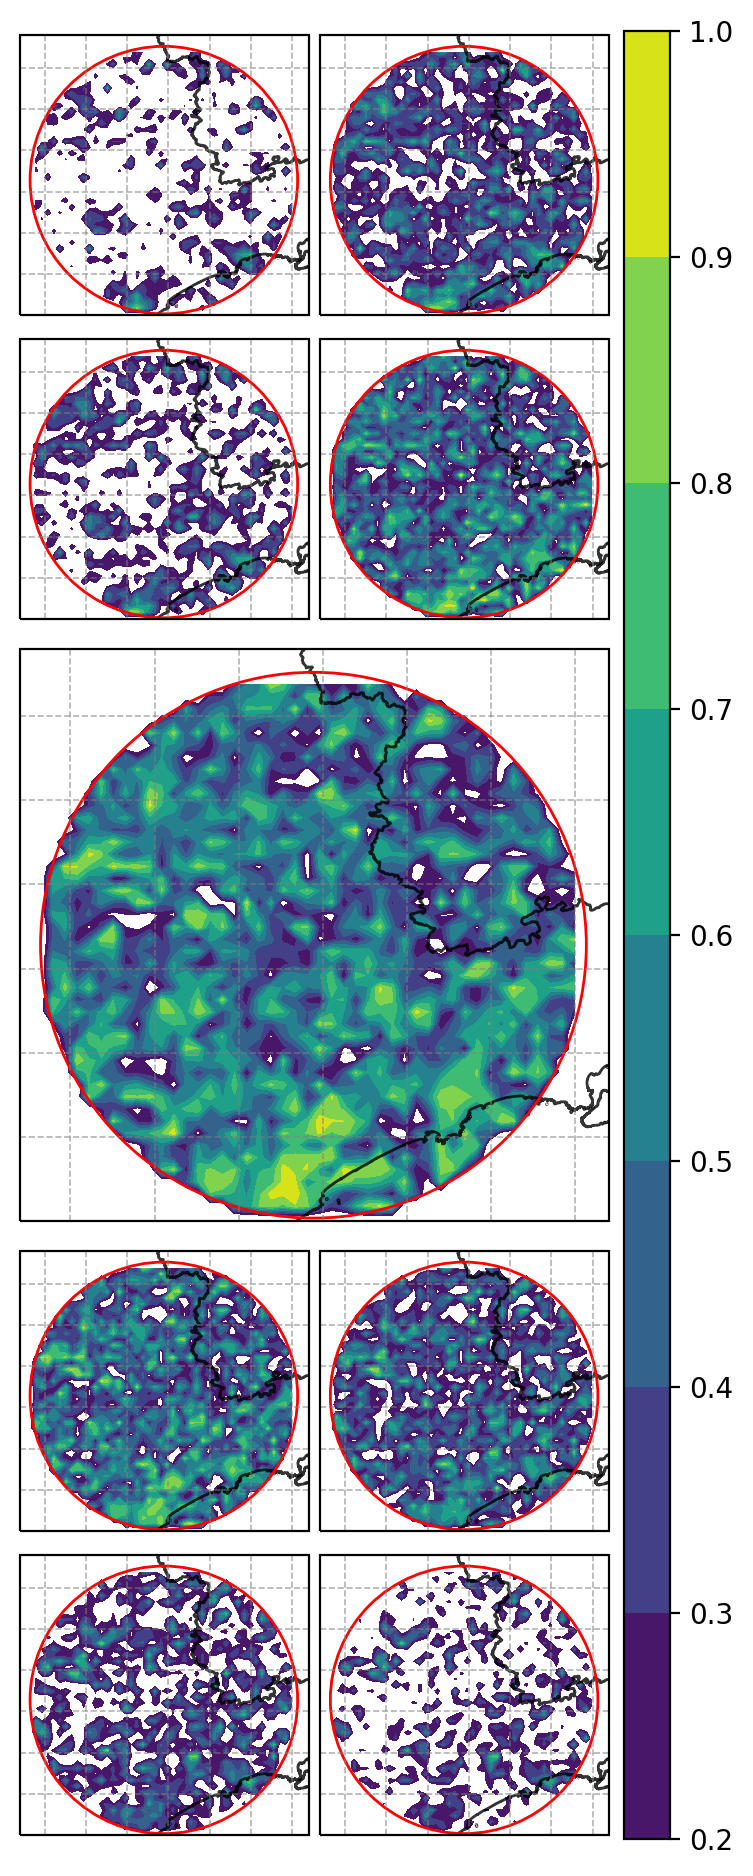

In [150]:
levels = np.arange(0.2,1.1,0.1)

fig = plt.figure(figsize=(3.8,12),dpi=200)

circle1 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle2 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle3 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle4 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)

circle5 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)

circle6 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle7 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle8 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)
circle9 = plt.Circle((lon_c,lat_c), r, color='red',fill=False)

gs = gridspec.GridSpec(6,2)

ax1 = plt.subplot(gs[0, 0], projection = proj)  
a1 = ax1.contourf(lon2d,lat2d,corr_espacial[0,:,:],levels=levels)
ax1.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax1.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax1.add_artist(circle1)

ax2 = plt.subplot(gs[1, 0], projection = proj) 
ax2.contourf(lon2d,lat2d,corr_espacial[1,:,:],levels=levels)
ax2.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax2.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax2.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax2.add_artist(circle2)

ax3 = plt.subplot(gs[0, 1], projection = proj)
ax3.contourf(lon2d,lat2d,corr_espacial[2,:,:],levels=levels)
ax3.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax3.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax3.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax3.add_artist(circle3)

ax4 = plt.subplot(gs[1, 1], projection = proj)
ax4.contourf(lon2d,lat2d,corr_espacial[3,:,:],levels=levels)
ax4.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax4.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax4.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax4.add_artist(circle4)

ax5 = plt.subplot(gs[2:4, 0:2], projection = proj)
ax5.contourf(lon2d,lat2d,corr_espacial[4,:,:],levels=levels)
ax5.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax5.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax5.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax5.add_artist(circle5)

ax6 = plt.subplot(gs[4, 0], projection = proj)
ax6.contourf(lon2d,lat2d,corr_espacial[5,:,:],levels=levels)
ax6.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax6.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax6.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax6.add_artist(circle6)

ax7 = plt.subplot(gs[4, 1], projection = proj)
ax7.contourf(lon2d,lat2d,corr_espacial[6,:,:],levels=levels)
ax7.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax7.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax7.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax7.add_artist(circle7)

ax8 = plt.subplot(gs[5, 0], projection = proj)
ax8.contourf(lon2d,lat2d,corr_espacial[7,:,:],levels=levels)
ax8.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax8.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax8.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax8.add_artist(circle8)

ax9 = plt.subplot(gs[5, 1], projection = proj)
ax9.contourf(lon2d,lat2d,corr_espacial[8,:,:],levels=levels)
ax9.add_geometries(shape, proj,edgecolor='black', facecolor='None', alpha=0.8)
ax9.set_extent([-48.8,-45.3,-24.5,-21.1])
gl = ax9.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
ax9.add_artist(circle9)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.04, wspace=0.04)

cbaxes = fig.add_axes([0.92, 0.1258, 0.06, 0.7535]) 
fig.colorbar(a1, cax = cbaxes,orientation="vertical")

salida = '../fig/GLM_Brasildat_'+name_out+'_espatial_cor.jpeg'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

In [151]:
print(tt_s,tt_e,name_out)
ll = len(G_new2[tt_s:tt_e,:,:])
corr_serie_lag = np.zeros(9)

serie_B0 = np.reshape(B_new2[tt_s:tt_e,:,:],ll*ny*nx)

serie_G20B = np.reshape(G_new2[tt_s-4:tt_e-4,:,:],ll*ny*nx)
serie_G15B = np.reshape(G_new2[tt_s-3:tt_e-3,:,:],ll*ny*nx)
serie_G10B = np.reshape(G_new2[tt_s-2:tt_e-2,:,:],ll*ny*nx)
serie_G5B = np.reshape(G_new2[tt_s-1:tt_e-1,:,:],ll*ny*nx)

serie_G0 = np.reshape(G_new2[tt_s:tt_e,:,:],ll*ny*nx)

serie_G5F = np.reshape(G_new2[tt_s+1:tt_e+1,:,:],ll*ny*nx)
serie_G10F = np.reshape(G_new2[tt_s+2:tt_e+2,:,:],ll*ny*nx)
serie_G15F = np.reshape(G_new2[tt_s+3:tt_e+3,:,:],ll*ny*nx)
serie_G20F = np.reshape(G_new2[tt_s+4:tt_e+4,:,:],ll*ny*nx)

corr_serie_lag[0] = pearsonr(serie_B0,serie_G20B)[0]
corr_serie_lag[1] = pearsonr(serie_B0,serie_G15B)[0]
corr_serie_lag[2] = pearsonr(serie_B0,serie_G10B)[0]
corr_serie_lag[3] = pearsonr(serie_B0,serie_G5B)[0]

corr_serie_lag[4] = pearsonr(serie_B0,serie_G0)[0]

corr_serie_lag[5] = pearsonr(serie_B0,serie_G5F)[0]
corr_serie_lag[6] = pearsonr(serie_B0,serie_G10F)[0]
corr_serie_lag[7] = pearsonr(serie_B0,serie_G15F)[0]
corr_serie_lag[8] = pearsonr(serie_B0,serie_G20F)[0]

4 8924 Complete


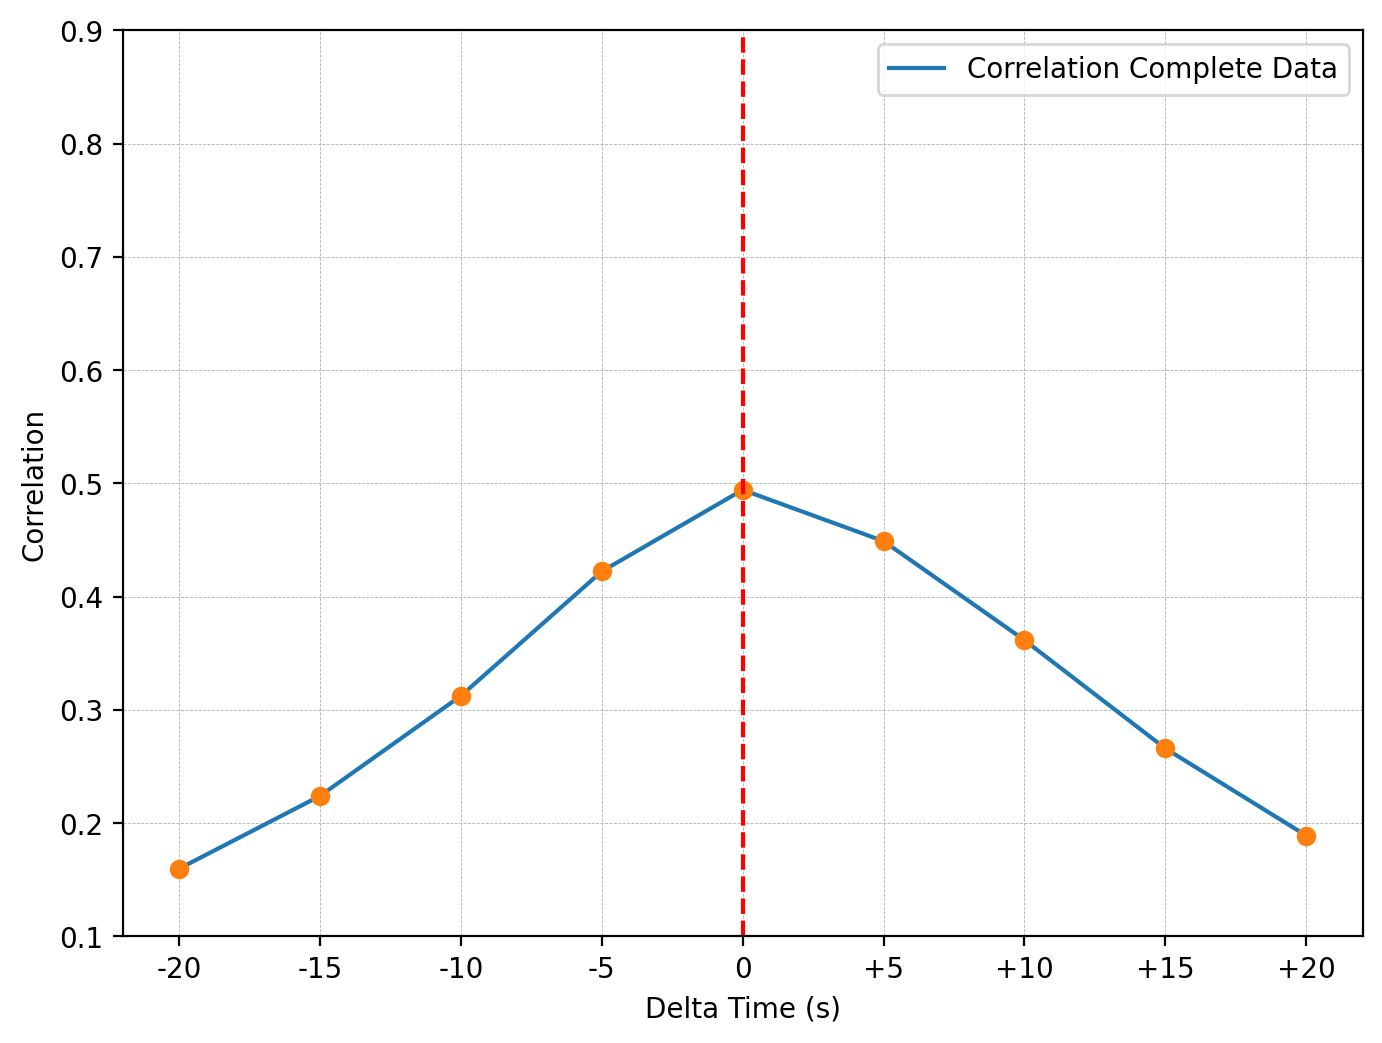

In [152]:
xtick = np.arange(9)
fig = plt.figure(figsize=(8,6),dpi=200)
plt.plot(corr_serie_lag,label='Correlation '+name_out+' Data')
plt.plot(corr_serie_lag,'o')
plt.axvline(x=4, color='r', linestyle='--')
plt.legend()
plt.grid(True,linewidth=0.3,linestyle='--')

plt.xticks(xtick, ('-20','-15','-10','-5','0','+5','+10','+15','+20'))

plt.xlabel('Delta Time (s)')
plt.ylabel('Correlation')

plt.ylim(0.1,0.9)

salida = '../fig/GLM_Brasildat_'+name_out+'_serie_cor.jpeg'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

## Diagrama de Taylor

In [153]:
Data_std = np.zeros(9)
Data_std[0] = np.std(serie_G20B)
Data_std[1] = np.std(serie_G15B)
Data_std[2] = np.std(serie_G10B)
Data_std[3] = np.std(serie_G5B)
Data_std[4] = np.std(serie_G0)
Data_std[5] = np.std(serie_G5F)
Data_std[6] = np.std(serie_G10F)
Data_std[7] = np.std(serie_G15F)
Data_std[8] = np.std(serie_G20F)

In [154]:
labels = ['-20','-15','-10','-5','0','5','10','15','20']

In [155]:
samples = [[Data_std[0], corr_serie_lag[0], "-20"],
           [Data_std[1], corr_serie_lag[1], "-15"],
           [Data_std[2], corr_serie_lag[2], "-10"],
           [Data_std[3], corr_serie_lag[3], "-5"],
           [Data_std[4], corr_serie_lag[4], "0"],
           [Data_std[5], corr_serie_lag[5], "5"],
           [Data_std[6], corr_serie_lag[6], "10"],
           [Data_std[7], corr_serie_lag[7], "15"],
           [Data_std[8], corr_serie_lag[8], "20"]]

stdref = np.max(Data_std)

In [156]:
colors = plt.matplotlib.cm.Set1(np.linspace(0,1,9))

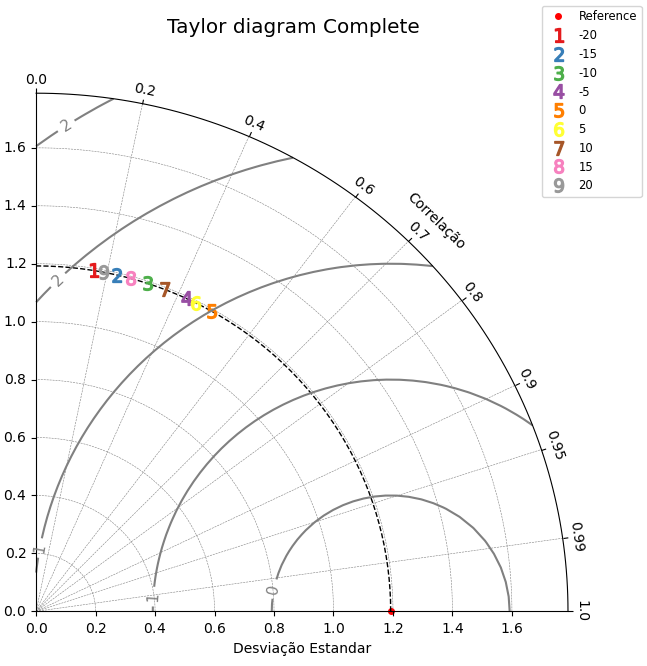

In [157]:
fig = plt.figure(figsize=(7,7),dpi=100)
dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=False)
dia.samplePoints[0].set_color('r')

for i, (stddev, corrcoef, name) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=name)
        
contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
plt.clabel(contours, inline=1, fontsize=11, fmt='%.0f')

dia.add_grid()                                  # Add grid
dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

fig.legend(dia.samplePoints,
    [ p.get_label() for p in dia.samplePoints ],ncol=1,
    numpoints=1, prop=dict(size='small'), loc=1)

fig.suptitle("Taylor diagram "+name_out, size='x-large')  # Figure title

salida = '../fig/GLM_Brasildat_'+name_out+'_Taylor.jpeg'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

## Diferentes Errores

In [158]:
def RMSE(data1,data2):

    DIFF = data1 - data2

    RMSE = np.sqrt(np.sum(DIFF*DIFF)/len(serie_B0))
        
    return RMSE 

In [159]:
Data_RMSE = np.zeros(9)

Data_RMSE[0] = RMSE(serie_B0,serie_G20B)
Data_RMSE[1] = RMSE(serie_B0,serie_G15B)
Data_RMSE[2] = RMSE(serie_B0,serie_G10B)
Data_RMSE[3] = RMSE(serie_B0,serie_G5B)

Data_RMSE[4] = RMSE(serie_B0,serie_G0)

Data_RMSE[5] = RMSE(serie_B0,serie_G5F)
Data_RMSE[6] = RMSE(serie_B0,serie_G10F)
Data_RMSE[7] = RMSE(serie_B0,serie_G15F)
Data_RMSE[8] = RMSE(serie_B0,serie_G20F)

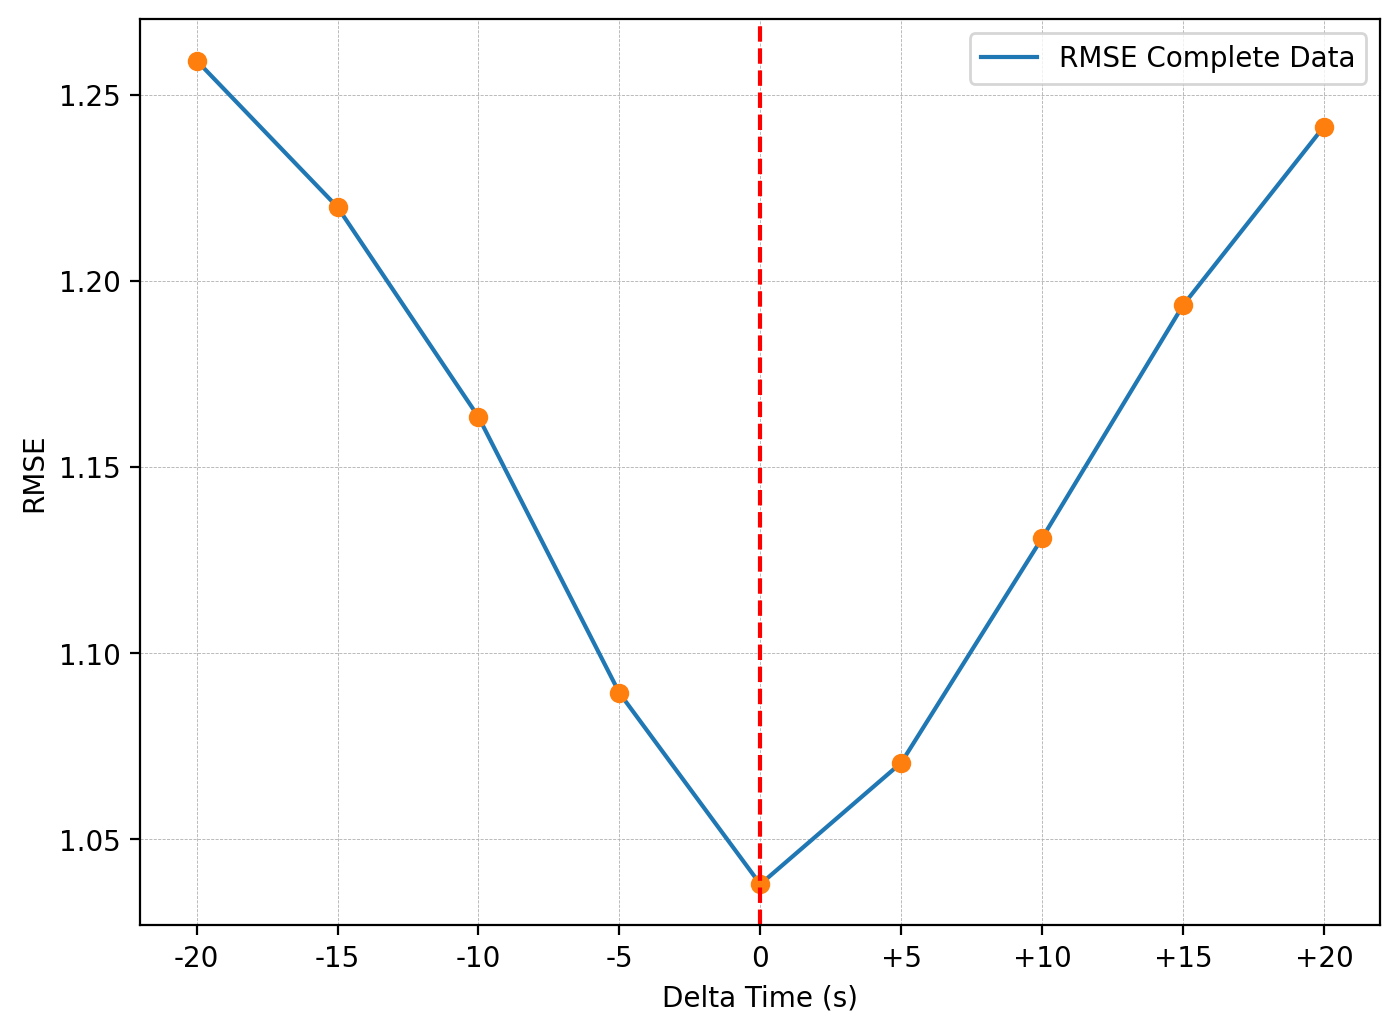

In [160]:
xtick = np.arange(9)
fig = plt.figure(figsize=(8,6),dpi=200)
plt.plot(Data_RMSE,label='RMSE '+name_out+' Data')
plt.plot(Data_RMSE,'o')
plt.axvline(x=4, color='r', linestyle='--')
plt.legend()
plt.grid(True,linewidth=0.3,linestyle='--')

plt.xticks(xtick, ('-20','-15','-10','-5','0','+5','+10','+15','+20'))

plt.xlabel('Delta Time (s)')
plt.ylabel('RMSE')

salida = '../fig/GLM_Brasildat_'+name_out+'_serie_RMSE.jpeg'

plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

In [162]:
tt = 216

print(time_B[tt])
print(time_B[tt+24])

corr_out02 = np.zeros([tt+24 - tt])
corr_out01 = np.zeros([tt+24 - tt])
corr_out0 = np.zeros([tt+24 - tt])
corr_out1 = np.zeros([tt+24 - tt])
corr_out2 = np.zeros([tt+24 - tt])
corr_out3 = np.zeros([tt+24 - tt])
corr_out4 = np.zeros([tt+24 - tt])
corr_out5 = np.zeros([tt+24 - tt])

count = 0
for t in range(tt,tt+24):
    G1 = np.reshape(G_new2[t,:,:],ny*nx)
    
    B02 = np.reshape(B_new2[t-3,:,:],ny*nx)
    B01 = np.reshape(B_new2[t-2,:,:],ny*nx)
    B0 = np.reshape(B_new2[t-1,:,:],ny*nx)
    B1 = np.reshape(B_new2[t,:,:],ny*nx)
    B2 = np.reshape(B_new2[t+1,:,:],ny*nx)
    B3 = np.reshape(B_new2[t+2,:,:],ny*nx)
    B4 = np.reshape(B_new2[t+3,:,:],ny*nx)
    B5 = np.reshape(B_new2[t+4,:,:],ny*nx)
    
    corr_02 = pearsonr(G1,B02)
    corr_out02[count] = corr_02[0]
    
    corr_01 = pearsonr(G1,B01)
    corr_out01[count] = corr_01[0]
    
    corr_0 = pearsonr(G1,B0)
    corr_out0[count] = corr_0[0]
    
    corr_1 = pearsonr(G1,B1)
    corr_out1[count] = corr_1[0]
    
    corr_2 = pearsonr(G1,B2)
    corr_out2[count] = corr_2[0]
    
    corr_3 = pearsonr(G1,B3)
    corr_out3[count] = corr_3[0]
    
    corr_4 = pearsonr(G1,B4)
    corr_out4[count] = corr_4[0]
    
    corr_5 = pearsonr(G1,B5)
    corr_out5[count] = corr_5[0]
    
    count = count + 1

2018-03-01 18:00:00
2018-03-01 20:00:00


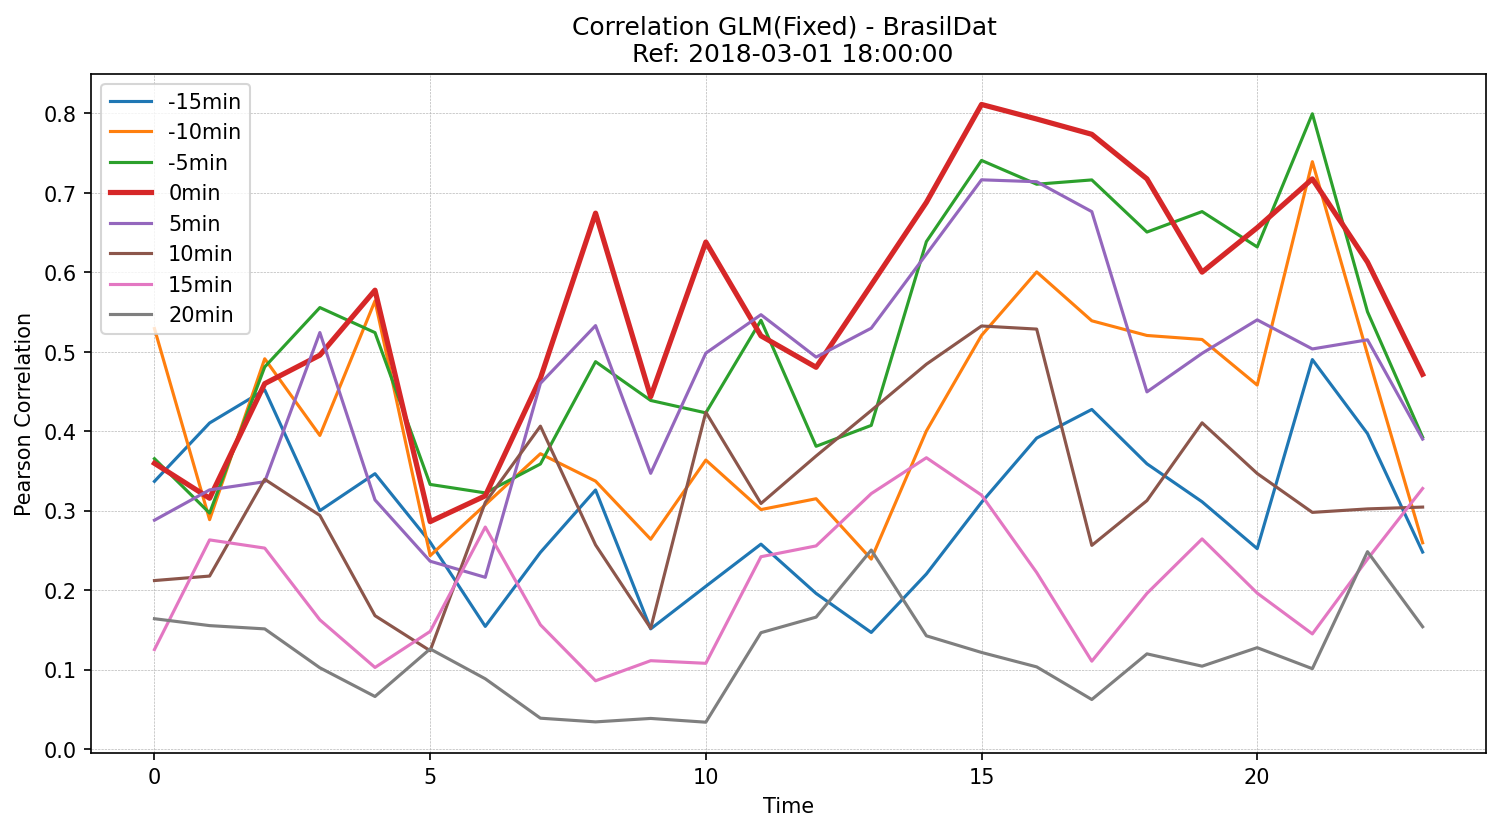

In [164]:
fig = plt.figure(figsize=(12,6),dpi=150)

plt.plot(corr_out02,label='-15min')
plt.plot(corr_out01,label='-10min')
plt.plot(corr_out0,label='-5min')
plt.plot(corr_out1,label='0min',linewidth=2.5)
plt.plot(corr_out2,label='5min')
plt.plot(corr_out3,label='10min')
plt.plot(corr_out4,label='15min')
plt.plot(corr_out5,label='20min')

plt.legend()
plt.grid(True,linestyle='--',linewidth=0.3)
plt.ylabel('Pearson Correlation')
plt.xlabel('Time')

title_cor = 'Correlation GLM(Fixed) - BrasilDat \n '+ 'Ref: '+str(time_B[tt])
plt.title(title_cor)

salida = '../fig/Corr_timeseries_GLM.jpeg'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

In [76]:
tt = 216

print(time_B[tt])
print(time_B[tt+24])

corr_out02 = np.zeros([tt+24 - tt])
corr_out01 = np.zeros([tt+24 - tt])
corr_out0 = np.zeros([tt+24 - tt])
corr_out1 = np.zeros([tt+24 - tt])
corr_out2 = np.zeros([tt+24 - tt])
corr_out3 = np.zeros([tt+24 - tt])
corr_out4 = np.zeros([tt+24 - tt])
corr_out5 = np.zeros([tt+24 - tt])

count = 0
for t in range(tt,tt+24):
    G1 = np.reshape(B_new2[t,:,:],ny*nx)
    
    B02 = np.reshape(G_new2[t-3,:,:],ny*nx)
    B01 = np.reshape(G_new2[t-2,:,:],ny*nx)
    B0 = np.reshape(G_new2[t-1,:,:],ny*nx)
    B1 = np.reshape(G_new2[t,:,:],ny*nx)
    B2 = np.reshape(G_new2[t+1,:,:],ny*nx)
    B3 = np.reshape(G_new2[t+2,:,:],ny*nx)
    B4 = np.reshape(G_new2[t+3,:,:],ny*nx)
    B5 = np.reshape(G_new2[t+4,:,:],ny*nx)
    
    corr_02 = pearsonr(G1,B02)
    corr_out02[count] = corr_02[0]
    
    corr_01 = pearsonr(G1,B01)
    corr_out01[count] = corr_01[0]
    
    corr_0 = pearsonr(G1,B0)
    corr_out0[count] = corr_0[0]
    
    corr_1 = pearsonr(G1,B1)
    corr_out1[count] = corr_1[0]
    
    corr_2 = pearsonr(G1,B2)
    corr_out2[count] = corr_2[0]
    
    corr_3 = pearsonr(G1,B3)
    corr_out3[count] = corr_3[0]
    
    corr_4 = pearsonr(G1,B4)
    corr_out4[count] = corr_4[0]
    
    corr_5 = pearsonr(G1,B5)
    corr_out5[count] = corr_5[0]
    
    count = count + 1

2019-03-01 18:00:00
2019-03-01 20:00:00


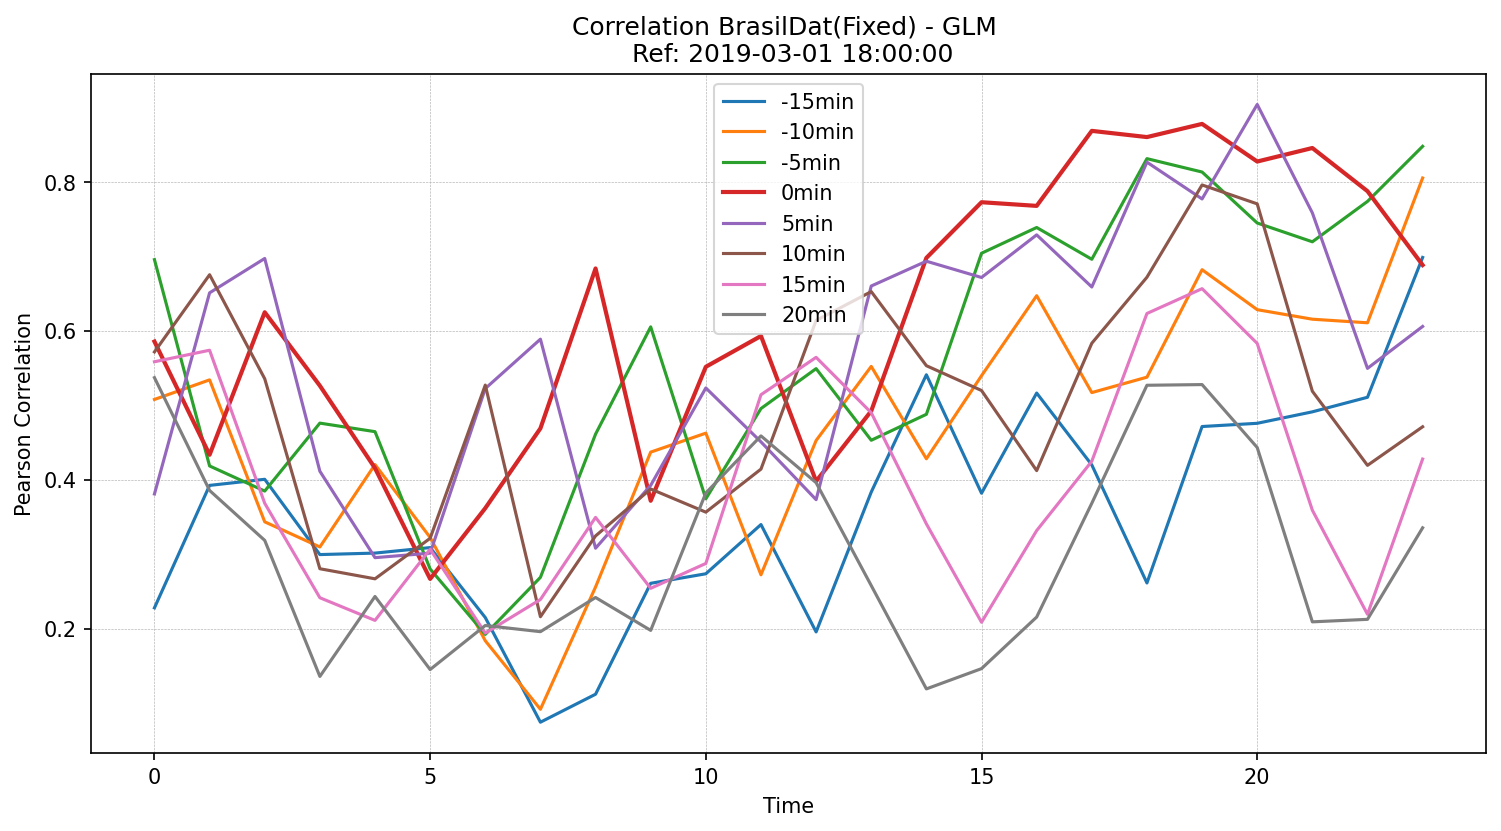

In [77]:
fig = plt.figure(figsize=(12,6),dpi=150)

plt.plot(corr_out02,label='-15min')
plt.plot(corr_out01,label='-10min')
plt.plot(corr_out0,label='-5min')
plt.plot(corr_out1,label='0min',linewidth=2)
plt.plot(corr_out2,label='5min')
plt.plot(corr_out3,label='10min')
plt.plot(corr_out4,label='15min')
plt.plot(corr_out5,label='20min')

plt.legend()
plt.grid(True,linestyle='--',linewidth=0.3)
plt.ylabel('Pearson Correlation')
plt.xlabel('Time')

title_cor = 'Correlation BrasilDat(Fixed) - GLM \n '+ 'Ref: '+str(time_B[tt])
plt.title(title_cor)

salida = '../fig/Corr_timeseries_BrasilDat.jpeg'
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)

In [165]:
Accum_G = np.zeros(24)
for h in range(24):
    suma = 0
    for i in range(31):
        tot = np.sum(np.sum(G_new2[i*12*24+12*h:i*12*24+12+12*h,:,:],axis = 0))
        suma = suma + tot
    Accum_G[h] = suma

In [166]:
Accum_B = np.zeros(24)
for h in range(24):
    suma = 0
    for i in range(31):
        tot = np.sum(np.sum(B_new2[i*12*24+12*h:i*12*24+12+12*h,:,:],axis = 0))
        suma = suma + tot
    Accum_B[h] = suma

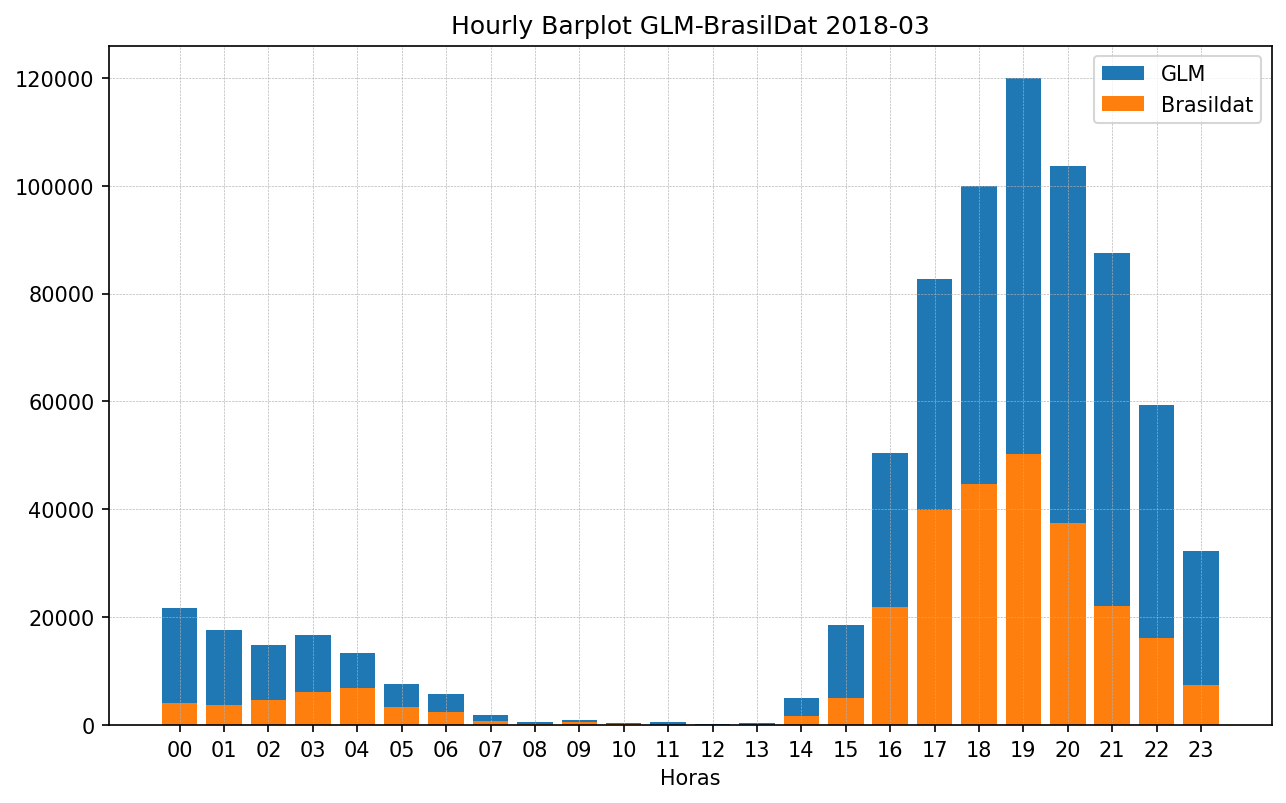

In [171]:
fig = plt.figure(figsize=(10,6),dpi=150)
x = np.arange(0,len(Accum_G))

plt.bar(x,Accum_G,label='GLM')
plt.bar(x,Accum_B,label='Brasildat')

plt.xticks(x, ('00','01','02','03','04','05','06','07','08','09','10','11','12',
               '13','14','15','16','17','18','19','20','21','22','23'))
plt.xlabel('Horas')
plt.grid(True,linewidth=0.3,linestyle='--')
plt.legend()
plt.title('Hourly Barplot GLM-BrasilDat 2018-03')

salida = '../fig/GLM_Brasildat_barplot_notitle.jpeg'
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1)